## Reading Data

In [2]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
#from google.colab import drive
#drive.mount('/content/drive')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import statsmodels.api as sm
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
warnings.filterwarnings("ignore", message=".*frozen modules.*")

Feature Setup

In [4]:
dir_data= "data"

In [11]:
from typing import Dict, final
def ingest_files(directory: str) -> Dict:
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.

    We assume the directory contains files directly downloaded from
    Lending Club, and *only* those files. Thus, we assume the files are zipped
    (pd.read_csv can read zipped files) and we assume the first line
    in each file needs to be skipped.

    Note that this function will read and ingest more than one file and is
    convenient if you want to ingest data for more than one year at a time.

    Note that each file will be read *without* formatting
    '''

    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"

    all_files = os.listdir(directory)
    output = {}

    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:

        if i.find('.csv')<0:
            continue

        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)


    return output

# Ingest the set of files we downloaded
files_data = ingest_files(dir_data)

data_now = pd.concat(files_data.values()).reset_index(drop = True)

# Identify the columns we'll be keeping from the dataset
cols_to_pick = [ #preselecetd
                'id','loan_amnt','funded_amnt','term','int_rate',
                 'installment','grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc','pub_rec',
                 'revol_bal','revol_util', 'total_pymnt',
                 'last_pymnt_d', 'recoveries',
                 #new selected
                 'acc_now_delinq', 'addr_state', 'bc_util',
                 'collections_12_mths_ex_med', 'mort_acc',
                 'num_bc_sats', 'num_bc_tl', 'pct_tl_nvr_dlq',
                  'pub_rec_bankruptcies', 'tax_liens', 'zip_code',
                 'total_acc', 'delinq_amnt']



# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'total_pymnt', 'recoveries', 'acc_now_delinq',
                                'collections_12_mths_ex_med', 'mort_acc', 'num_bc_sats',
              'num_bc_tl','pub_rec_bankruptcies','tax_liens',
              'bc_util', 'pct_tl_nvr_dlq', 'total_acc', 'delinq_amnt']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'zip_code',
                    'verification_status', 'loan_status', 'purpose', 'addr_state']
perc_cols = ['int_rate', 'revol_util' ]
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

final_data = data_now[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

Directory /content/drive/MyDrive/mini4/BizValue/Update1/data/ has 1 files:
    Reading file 2014.csv
Starting with 235631 rows


In [12]:
for i in float_cols:
    final_data[i] = final_data[i].astype(float)

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.rstrip()[:-1])
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()
for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )

for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None

final_data['zip_code'] = final_data['zip_code'].str.replace('xx', '', regex=False)

#Removing the id columns - since the id column is null
final_data.drop('id', axis=1, inplace=True)

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

final_data['credit_line_loan_gap'] = (final_data.issue_d - final_data.earliest_cr_line)/np.timedelta64(365, 'D')

final_data = final_data.drop([ 'earliest_cr_line'], axis=1)

float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'total_pymnt', 'recoveries', 'acc_now_delinq',
                                'collections_12_mths_ex_med', 'mort_acc', 'num_bc_sats',
              'num_bc_tl','pub_rec_bankruptcies','tax_liens',
              'bc_util', 'pct_tl_nvr_dlq', 'credit_line_loan_gap']

Removed 2747 rows


## 1. Default Probability & Signal Leakage Determining

In [ ]:
# Create a binary target variable 'default'
# A loan is considered defaulted if its loan_status is "Charged Off"
final_data['default'] = final_data['loan_status'].apply(lambda x: 1 if x in ['Default', 'Charged Off', 'Charged-Off'] else 0)

# Prepare the feature set using all available attributes from your large subset.
# Remove columns that are not features: 'loan_status' and the target 'default'
feature_cols = final_data.columns.drop(['loan_status', 'default'])
X = final_data[feature_cols]
y = final_data['default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cat_cols_updated = [col for col in cat_cols if col in X_train.columns]

# Encode categorical variables using one-hot encoding
X_train = pd.get_dummies(X_train, columns=cat_cols_updated, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols_updated, drop_first=True)

# Align train and test sets to ensure they have the same features
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Convert Date Columns to Ordinal
for col in date_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].apply(lambda date: date.toordinal() if date is not None else np.nan)
        X_test[col] = X_test[col].apply(lambda date: date.toordinal() if date is not None else np.nan)


Logistic Regression

In [ ]:
# Fit Logistic Regression on all features
model_lr = LogisticRegression(max_iter=100, solver='liblinear')
model_lr.fit(X_train, y_train)

# Evaluate the model
y_pred_proba = model_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_proba)
print("Logistic Regression")
print("AUC:", auc_lr)

y_pred = model_lr.predict(X_test)
accuracy_signal = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_signal)

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

baseline_positive_rate = y_test.mean()
predicted_positive_rate = (y_pred == 1).mean()
lift = predicted_positive_rate / baseline_positive_rate
print("Lift:", lift)

cm_signal = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm_signal)

tn, fp, fn, tp = cm_signal.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
recall = recall_score(y_test, y_pred)
print("Specificity:", specificity)
print("Recall:", recall)

Logistic Regression
AUC: 0.9936723099178856
Accuracy: 0.9882918730140555
F1 Score: 0.965467747382641
Lift: 0.9343459088682019
Confusion Matrix:
[[57613     7]
 [  811 11435]]
Specificity: 0.9998785144047205
Recall: 0.9337742936469051


In [ ]:
# Inspect Coefficients
# Extract and display the top 10 features (by coefficient magnitude)
coefficients = pd.Series(model_lr.coef_[0], index=X_train.columns)
print("\nTop 10 positive coefficients:")
print(coefficients.sort_values(ascending=False).head(10))
print("\nTop 10 negative coefficients:")
print(coefficients.sort_values().head(10))


Top 10 positive coefficients:
recoveries         0.023132
last_pymnt_d       0.003599
bc_util            0.001690
revol_util         0.001295
loan_amnt          0.000897
funded_amnt        0.000897
int_rate           0.000872
dti                0.000331
delinq_amnt        0.000121
term_ 60 months    0.000033
dtype: float64

Top 10 negative coefficients:
issue_d                -0.003607
total_pymnt            -0.001624
installment            -0.001322
pct_tl_nvr_dlq         -0.000152
total_acc              -0.000130
credit_line_loan_gap   -0.000100
mort_acc               -0.000046
num_bc_tl              -0.000030
grade_B                -0.000023
purpose_credit_card    -0.000020
dtype: float64


Signal leakage is influenced by the following factors: Recoveries, Last Payment Date

Decision Tree

In [ ]:
# Train a Decision Tree Classifier
model_dt = DecisionTreeClassifier(random_state=42, max_depth=8)
model_dt.fit(X_train, y_train)

# Evaluate the model
y_pred_proba = model_dt.predict_proba(X_test)[:, 1]
auc_dt = roc_auc_score(y_test, y_pred_proba)
print("Decision Tree")
print("AUC:", auc_dt)

y_pred = model_dt.predict(X_test)
accuracy_signal = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_signal)

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

baseline_positive_rate = y_test.mean()
predicted_positive_rate = (y_pred == 1).mean()
lift = predicted_positive_rate / baseline_positive_rate
print("Lift:", lift)

cm_signal = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm_signal)

tn, fp, fn, tp = cm_signal.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
recall = recall_score(y_test, y_pred)
print("Specificity:", specificity)
print("Recall:", recall)

Decision Tree
AUC: 0.9861564944837019
Accuracy: 0.9918987776600922
F1 Score: 0.9763575605680869
Lift: 0.9549240568348849
Confusion Matrix:
[[57613     7]
 [  559 11687]]
Specificity: 0.9998785144047205
Recall: 0.9543524416135881


In [ ]:
# Compute and display feature importances
importances = model_dt.feature_importances_
features = X_train.columns
feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df.sort_values(by='importance', ascending=False, inplace=True)
print("\nTop 20 Feature Importances:")
print(feat_imp_df.head(20))



Top 20 Feature Importances:
                          feature  importance
14                     recoveries    0.768866
0                       loan_amnt    0.151078
12                    total_pymnt    0.053010
1                     funded_amnt    0.013838
3                     installment    0.008353
13                   last_pymnt_d    0.003389
2                        int_rate    0.000682
27                term_ 60 months    0.000419
29                        grade_C    0.000093
360                  zip_code_354    0.000044
761                  zip_code_860    0.000043
11                     revol_util    0.000042
893                 addr_state_CA    0.000035
877  verification_status_Verified    0.000029
383                  zip_code_378    0.000022
874                  zip_code_998    0.000022
157                  zip_code_139    0.000014
588                  zip_code_638    0.000011
15                 acc_now_delinq    0.000009
625                  zip_code_700    0.000000


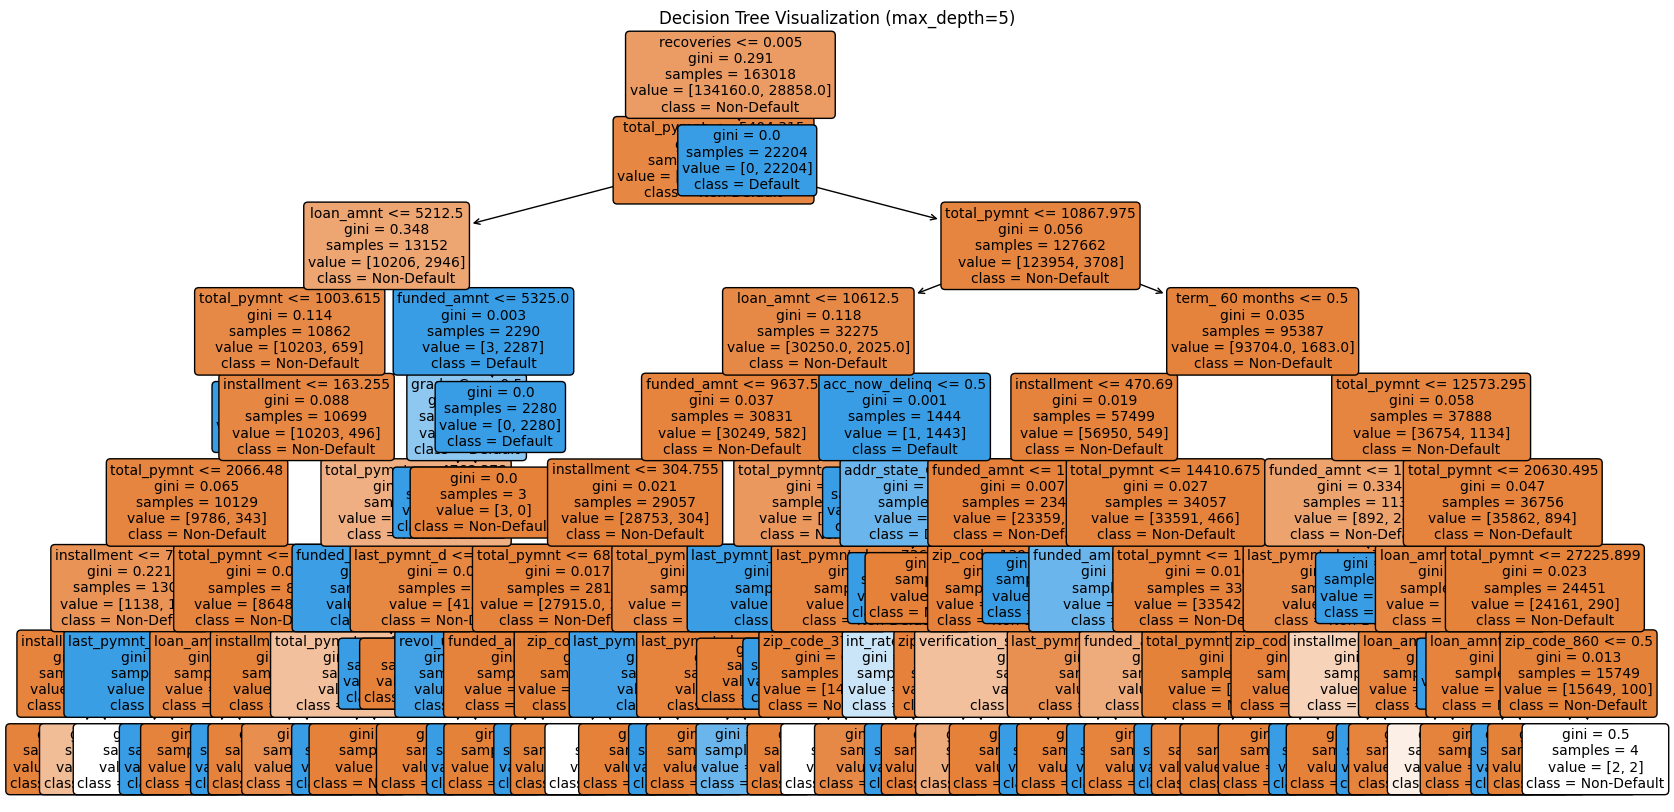

In [ ]:
# Print decision tree rules for interpretation
plt.figure(figsize=(20, 10))
plot_tree(
    model_dt,
    feature_names=X_train.columns,
    class_names=["Non-Default", "Default"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (max_depth=5)")
plt.show()

In [ ]:
# Identify potential leakage variables
leakage_vars = ['total_pymnt', 'last_pymnt_d', 'recoveries', 'grade', 'int_rate']
print("\nPotential Leakage Variables:")
for var in leakage_vars:
    if var in feat_imp_df['feature'].values:
        imp_val = feat_imp_df.loc[feat_imp_df['feature'] == var, 'importance'].iloc[0]
        print(f" - {var}: importance = {imp_val:.4f}")
    else:
        print(f" - {var} not found in the feature importance table.")


Potential Leakage Variables:
 - total_pymnt: importance = 0.0530
 - last_pymnt_d: importance = 0.0034
 - recoveries: importance = 0.7689
 - grade not found in the feature importance table.
 - int_rate: importance = 0.0007


## 2. Using only Grade and Interest Rate

In [ ]:
final_data['default'] = final_data['loan_status'].apply(lambda x: 1 if x in ['Default', 'Charged Off', 'Charged-Off'] else 0)

# Subset the Data to Only Include 'grade', 'int_rate', and the Target
data_signal = final_data[['grade', 'int_rate', 'default']].copy()

# Encode the 'grade' Variable
data_signal = pd.get_dummies(data_signal, columns=['grade'], drop_first=True)

X_signal = data_signal.drop(columns=['default'])
y_signal = data_signal['default']

X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(X_signal, y_signal, test_size=0.3, random_state=42, stratify=y_signal)


Logistic Regression Regression

In [ ]:
model_lr_signal = LogisticRegression(max_iter=1000)
model_lr_signal.fit(X_train_sig, y_train_sig)

y_pred_proba_signal = model_lr_signal.predict_proba(X_test_sig)[:, 1]
auc_signal = roc_auc_score(y_test_sig, y_pred_proba_signal)
print("Logistic Regression using only Grade and Interest Rate:")
print("AUC:", auc_signal)

y_pred_signal = model_lr_signal.predict(X_test_sig)
accuracy_signal = accuracy_score(y_test_sig, y_pred_signal)
print("Accuracy:", accuracy_signal)

f1 = f1_score(y_test_sig, y_pred_signal)
print("F1 Score:", f1)

baseline_positive_rate = y_test_sig.mean()
predicted_positive_rate = (y_pred_signal == 1).mean()
lift = predicted_positive_rate / baseline_positive_rate
print("Lift:", lift)

cm_signal = confusion_matrix(y_test_sig, y_pred_signal)
print("Confusion Matrix:")
print(cm_signal)

tn, fp, fn, tp = cm_signal.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
recall = recall_score(y_test_sig, y_pred_signal)
print("Specificity:", specificity)
print("Recall:", recall)

Logistic Regression using only Grade and Interest Rate:
AUC: 0.678827955047224
Accuracy: 0.8235049952766725
F1 Score: 0.0
Lift: 0.0
Confusion Matrix:
[[57535     0]
 [12331     0]]
Specificity: 1.0
Recall: 0.0


Decision Tree

In [ ]:
model_dt_signal = DecisionTreeClassifier(random_state=42, max_depth=8)
model_dt_signal.fit(X_train_sig, y_train_sig)

y_pred_proba_signal = model_dt_signal.predict_proba(X_test_sig)[:, 1]
auc_signal = roc_auc_score(y_test_sig, y_pred_proba_signal)
print("Decision Tree using only Grade and Interest Rate:")
print("AUC:", auc_signal)

y_pred_signal = model_dt_signal.predict(X_test_sig)
accuracy_signal = accuracy_score(y_test_sig, y_pred_signal)
print("Accuracy:", accuracy_signal)

f1 = f1_score(y_test_sig, y_pred_signal)
print("F1 Score:", f1)

baseline_positive_rate = y_test_sig.mean()
predicted_positive_rate = (y_pred_signal == 1).mean()
lift = predicted_positive_rate / baseline_positive_rate
print("Lift:", lift)

cm_signal = confusion_matrix(y_test_sig, y_pred_signal)
print("Confusion Matrix:")
print(cm_signal)

tn, fp, fn, tp = cm_signal.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
recall = recall_score(y_test_sig, y_pred_signal)
print("Specificity:", specificity)
print("Recall:", recall)

Decision Tree using only Grade and Interest Rate:
AUC: 0.680178048759156
Accuracy: 0.8235049952766725
F1 Score: 0.0
Lift: 0.0
Confusion Matrix:
[[57535     0]
 [12331     0]]
Specificity: 1.0
Recall: 0.0


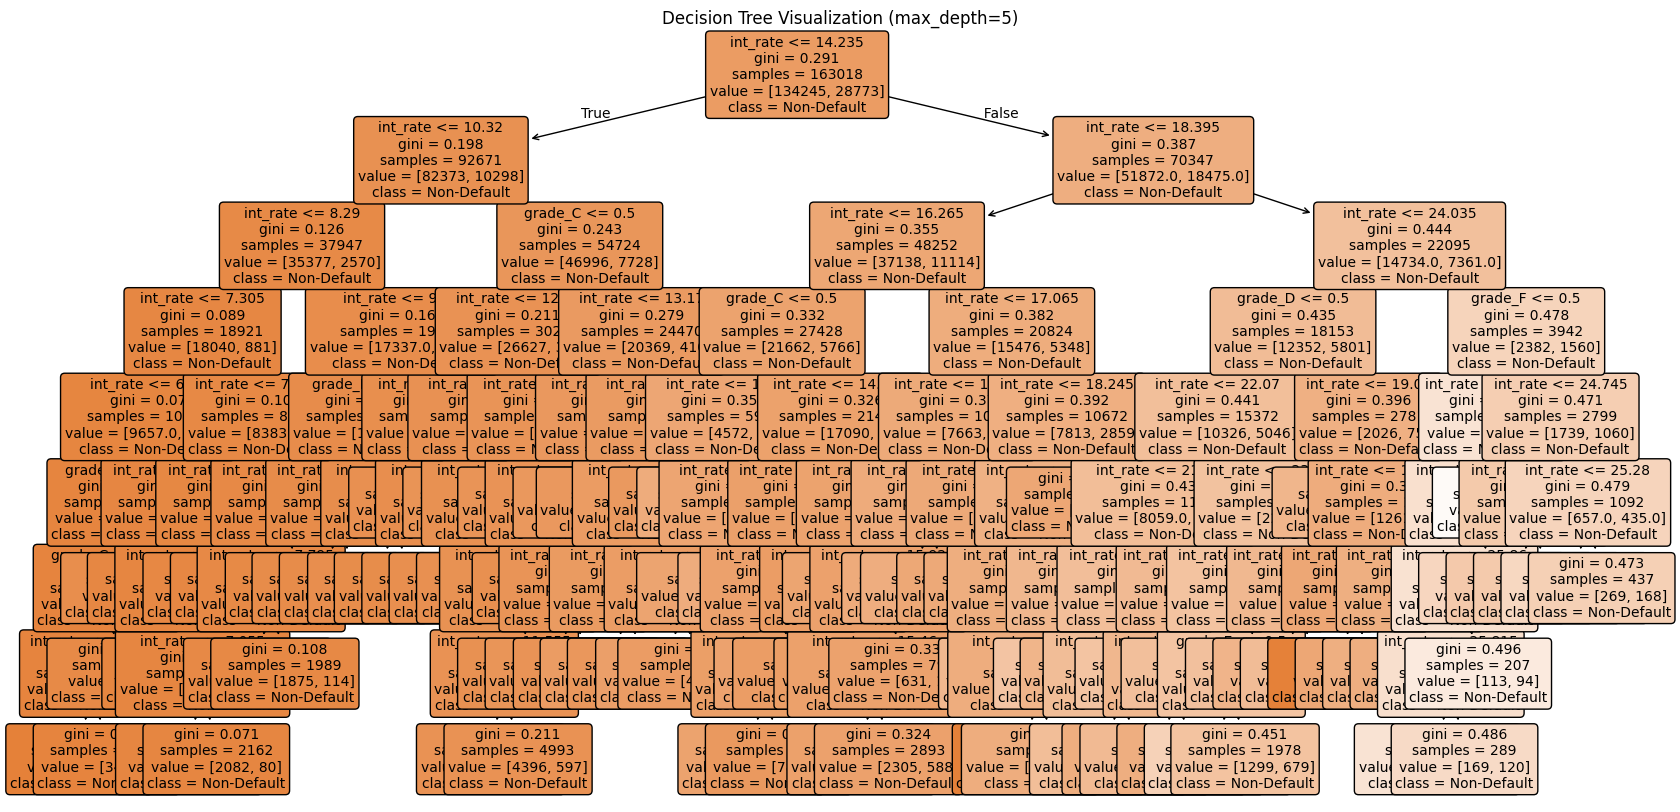

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(
    model_dt_signal,
    feature_names=X_train_sig.columns,
    class_names=["Non-Default", "Default"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (max_depth=5)")
plt.show()

## 3. Downsampling

## 4. Default Prediction on Variables Available at the time of Loan Application

In [ ]:
#Using all the variables at the time
new_cols = ['loan_amnt', 'purpose', 'term', 'home_ownership', 'emp_length',
            'zip_code', 'annual_inc','dti', 'earliest_cr_line', 'open_acc', 'total_acc', 'revol_bal',
            'revol_util', 'acc_now_delinq','delinq_amnt', 'delinq_2yrs', 'pub_rec', 'loan_status']

# Identify the type of each of these column
float_cols = ['loan_amnt', 'annual_inc', 'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'total_acc',
              'pub_rec', 'acc_now_delinq', 'delinq_amnt']
cat_cols = ['term', 'emp_length', 'home_ownership', 'zip_code','purpose', 'loan_status']
perc_cols = ['revol_util' ]
date_cols = ['earliest_cr_line']

# Ensure that we have types for every column

assert set(new_cols) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set()

new_dp_data = data_now[new_cols].copy()

In [ ]:
for i in float_cols:
    new_dp_data[i] = new_dp_data[i].astype(float)

for i in perc_cols:
    new_dp_data[i] = new_dp_data[i].apply( clean_perc )

for i in date_cols:
    new_dp_data[i] = new_dp_data[i].apply( clean_date )

for i in cat_cols:
    new_dp_data.loc[new_dp_data[i].isnull(), i] = None

new_dp_data['zip_code'] = new_dp_data['zip_code'].str.replace('xx', '', regex=False)

required_cols = set(new_cols) - set(cat_cols) - set(["id"])

n_rows = len(new_dp_data)
new_dp_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 2747 rows


In [ ]:
new_dp_data['default'] = new_dp_data['loan_status'].apply(lambda x: 1 if x in ['Default', 'Charged Off', 'Charged-Off'] else 0)

feature_cols = new_dp_data.columns.drop(['loan_status', 'default'])
X = new_dp_data[feature_cols]
y = new_dp_data['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cat_cols_updated = [col for col in cat_cols if col in X_train.columns]

X_train = pd.get_dummies(X_train, columns=cat_cols_updated, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols_updated, drop_first=True)

X_train, X_test = X_train.align(X_test, join='inner', axis=1)

for col in date_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].apply(lambda date: date.toordinal() if date is not None else np.nan)
        X_test[col] = X_test[col].apply(lambda date: date.toordinal() if date is not None else np.nan)


Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)

# Predict probabilities and classes
y_pred_lr_proba = lr_model.predict_proba(X_test)[:, 1]
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
auc_lr = roc_auc_score(y_test, y_pred_lr_proba)
print("Logistic Regression Results:")
print("AUC:", auc_lr)

acc_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", acc_lr)

f1 = f1_score(y_test, y_pred_lr)
print("F1 Score:", f1)

baseline_positive_rate = y_test.mean()
predicted_positive_rate = (y_pred_lr == 1).mean()
lift = predicted_positive_rate / baseline_positive_rate
print("Lift:", lift)

cm_signal = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(cm_signal)

tn, fp, fn, tp = cm_signal.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
recall = recall_score(y_test, y_pred_lr)
print("Specificity:", specificity)
print("Recall:", recall)

Logistic Regression Results:
AUC: 0.6163702297567644
Accuracy: 0.8260488025816679
F1 Score: 0.00016270745200130165
Lift: 0.0001627339300244101
Confusion Matrix:
[[58361     1]
 [12289     1]]
Specificity: 0.9999828655632089
Recall: 8.136696501220504e-05


Total number of features used in logistic regression: 869

Top 10 features by absolute coefficient value:
                        Feature  Coefficient  Abs_Coefficient
4                      open_acc     0.039781         0.039781
12              term_ 60 months     0.022863         0.022863
2                           dti     0.020673         0.020673
5                     total_acc    -0.011960         0.011960
24          home_ownership_RENT     0.009066         0.009066
857         purpose_credit_card    -0.007027         0.007027
7                    revol_util     0.006965         0.006965
10                  delinq_2yrs     0.006202         0.006202
11                      pub_rec     0.004562         0.004562
858  purpose_debt_consolidation     0.003058         0.003058


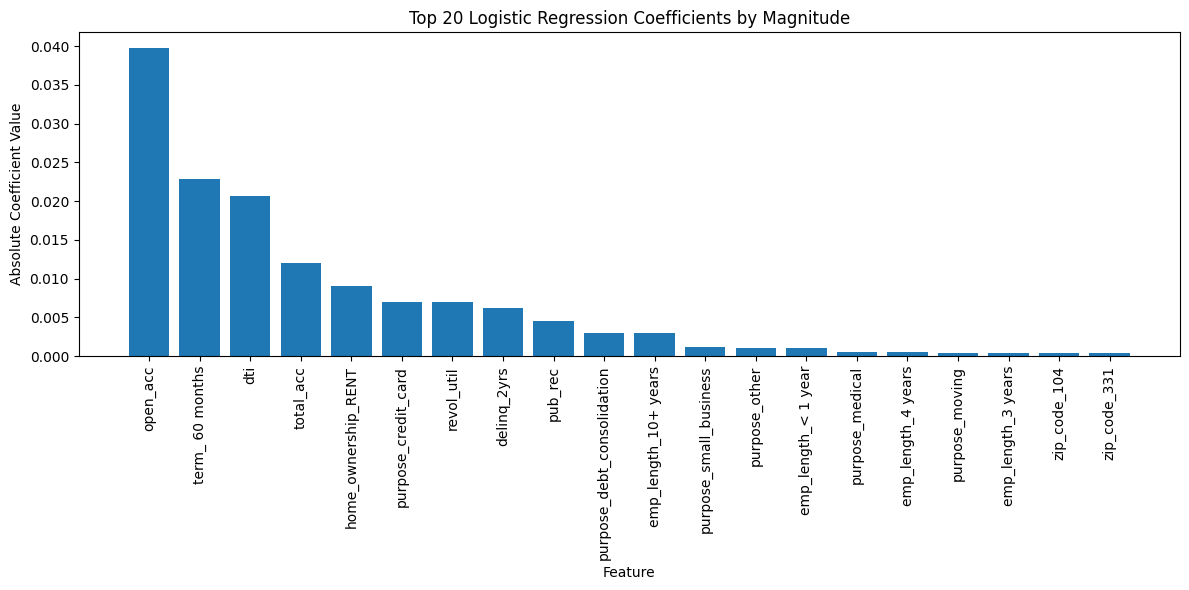

In [ ]:
num_features = X_train.shape[1]
print(f"Total number of features used in logistic regression: {num_features}")

# Coefficients
feature_names = X_train.columns
coefficients = lr_model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Display top features
print("\nTop 10 features by absolute coefficient value:")
print(coef_df.head(10))

# Plot the coefficient magnitudes
plt.figure(figsize=(12, 6))
plt.bar(coef_df['Feature'][:20], coef_df['Abs_Coefficient'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Logistic Regression Coefficients by Magnitude')
plt.ylabel('Absolute Coefficient Value')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42, max_depth=8)
dt_model.fit(X_train, y_train)

# Predict probabilities and classes
y_pred_dt_proba = dt_model.predict_proba(X_test)[:, 1]
y_pred_dt = dt_model.predict(X_test)

# Evaluate performance
auc_dt = roc_auc_score(y_test, y_pred_dt_proba)
print("Decision Tree Results:")
print("AUC:", auc_dt)

acc_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", acc_dt)

f1 = f1_score(y_test, y_pred_dt)
print("F1 Score:", f1)

baseline_positive_rate = y_test.mean()
predicted_positive_rate = (y_pred_dt == 1).mean()
lift = predicted_positive_rate / baseline_positive_rate
print("Lift:", lift)

cm_signal = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
print(cm_signal)

tn, fp, fn, tp = cm_signal.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
recall = recall_score(y_test, y_pred_dt)
print("Specificity:", specificity)
print("Recall:", recall)

Decision Tree Results:
AUC: 0.6425891999400282
Accuracy: 0.8236567966936534
F1 Score: 0.020749823154916292
Lift: 0.035231895850284786
Confusion Matrix:
[[58061   301]
 [12158   132]]
Specificity: 0.9948425345258901
Recall: 0.010740439381611067



Decision Tree Complexity:
Tree Depth: 8
Number of Leaves: 212

Top 10 Important Features:
                Feature  Importance
12      term_ 60 months    0.421646
1            annual_inc    0.129106
2                   dti    0.085251
24  home_ownership_RENT    0.079272
3      earliest_cr_line    0.051530
6             revol_bal    0.043562
7            revol_util    0.034521
0             loan_amnt    0.026571
4              open_acc    0.015064
5             total_acc    0.011635


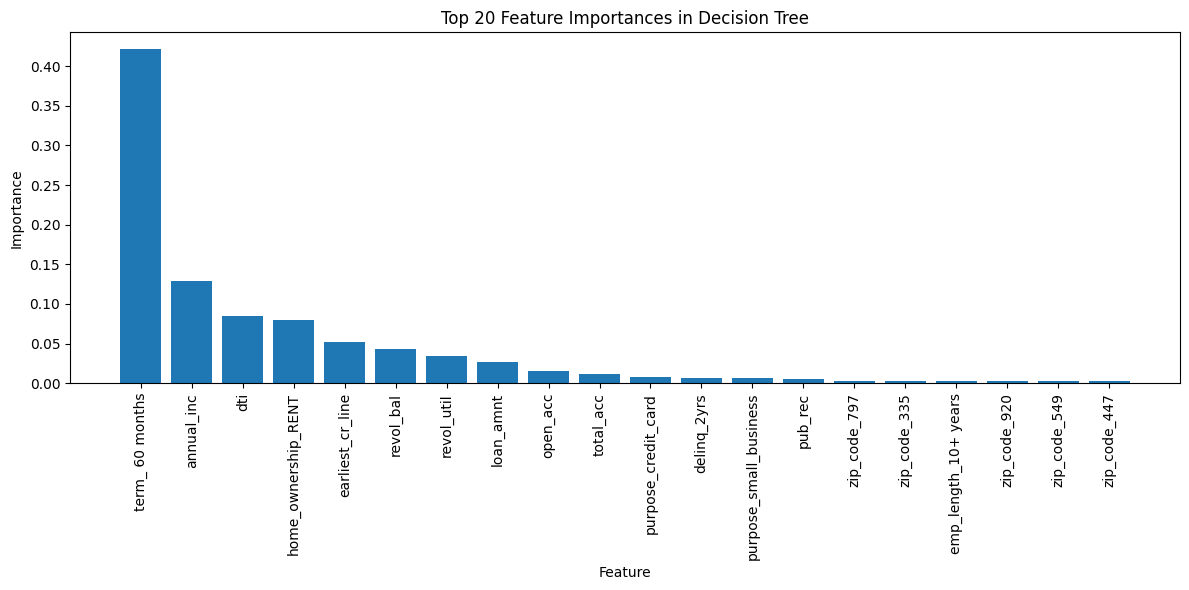

In [ ]:
print("\nDecision Tree Complexity:")
print("Tree Depth:", dt_model.get_depth())
print("Number of Leaves:", dt_model.get_n_leaves())

# 2. Feature importance
importances = dt_model.feature_importances_
feature_names = X_train.columns

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Important Features:")
print(importances_df.head(10))

# 3. Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(importances_df['Feature'][:20], importances_df['Importance'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Feature Importances in Decision Tree')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

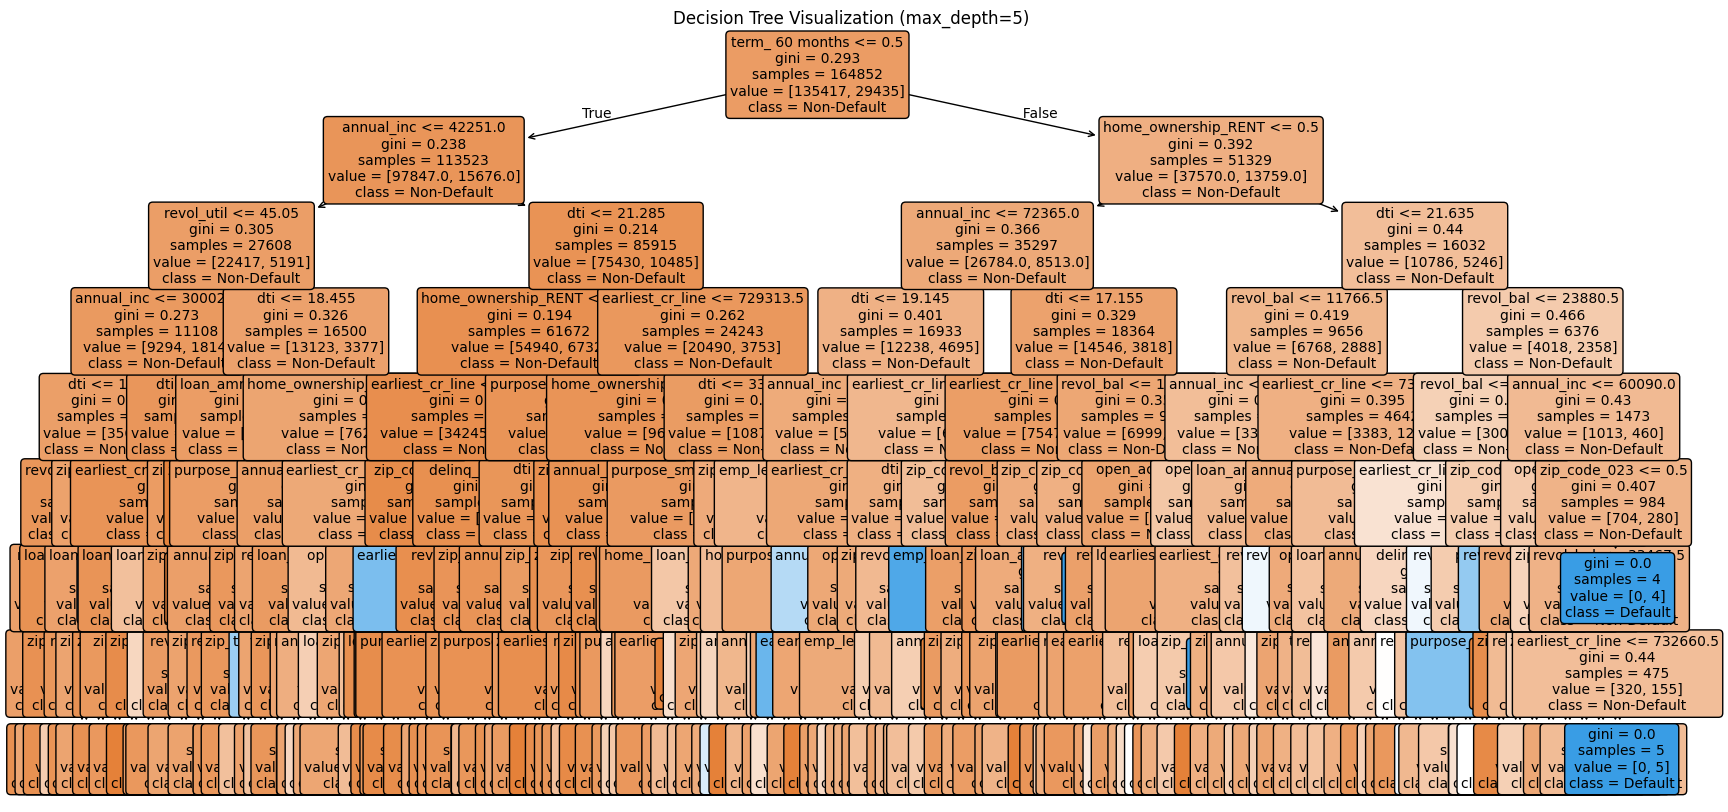

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X_train.columns,
    class_names=["Non-Default", "Default"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (max_depth=5)")
plt.show()

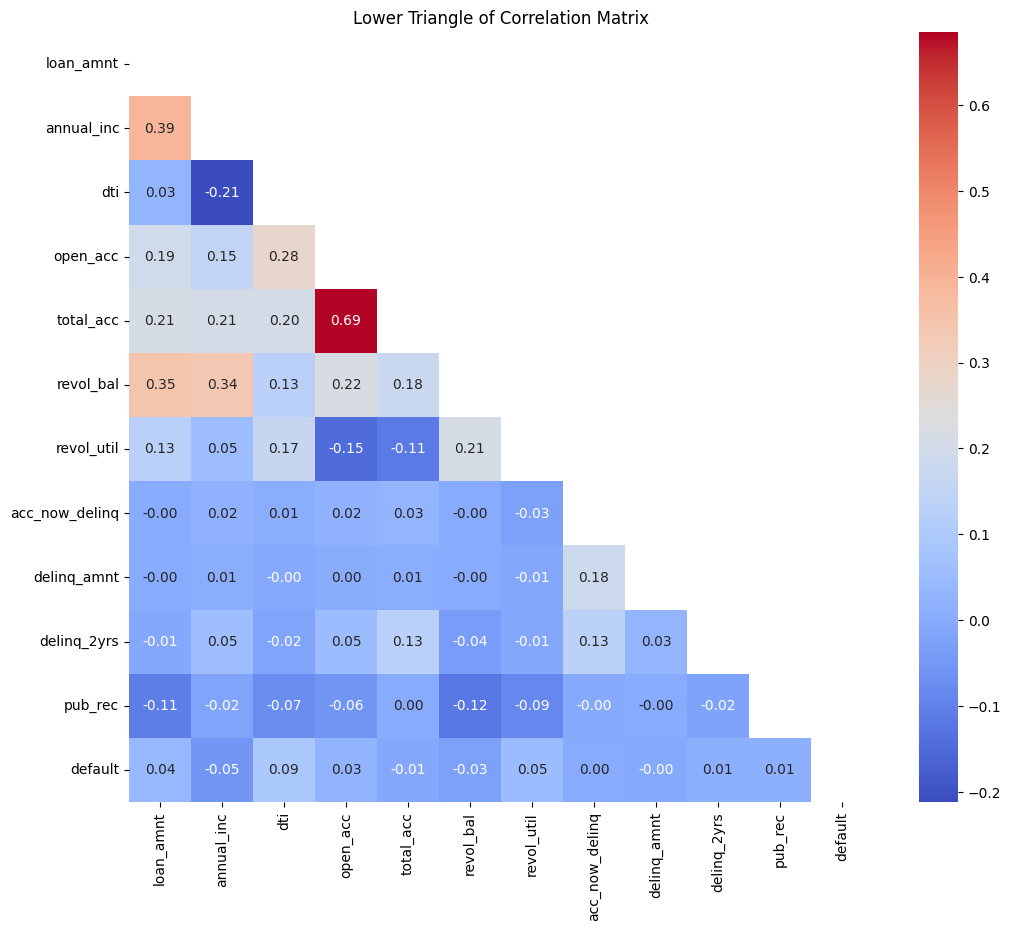

In [ ]:
numeric_cols = new_dp_data.select_dtypes(include=[np.number]).columns
corr_matrix = new_dp_data[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Apply the mask to get only the lower triangle
lower_corr = corr_matrix.mask(mask)

# Optionally, plot the lower triangle heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(lower_corr, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title("Lower Triangle of Correlation Matrix")
plt.show()

In [ ]:
new_dp_data=new_dp_data.drop(columns=['total_acc'])
new_dp_data['default'] = new_dp_data['loan_status'].apply(lambda x: 1 if x in ['Default', 'Charged Off', 'Charged-Off'] else 0)

feature_cols = new_dp_data.columns.drop(['loan_status', 'default'])
X = new_dp_data[feature_cols]
y = new_dp_data['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cat_cols_updated = [col for col in cat_cols if col in X_train.columns]

X_train = pd.get_dummies(X_train, columns=cat_cols_updated, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols_updated, drop_first=True)

X_train, X_test = X_train.align(X_test, join='inner', axis=1)

for col in date_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].apply(lambda date: date.toordinal() if date is not None else np.nan)
        X_test[col] = X_test[col].apply(lambda date: date.toordinal() if date is not None else np.nan)


Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)

# Predict probabilities and classes
y_pred_lr_proba = lr_model.predict_proba(X_test)[:, 1]
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
auc_lr = roc_auc_score(y_test, y_pred_lr_proba)
print("Logistic Regression Results:")
print("AUC:", auc_lr)

acc_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", acc_lr)

f1 = f1_score(y_test, y_pred_lr)
print("F1 Score:", f1)

baseline_positive_rate = y_test.mean()
predicted_positive_rate = (y_pred_lr == 1).mean()
lift = predicted_positive_rate / baseline_positive_rate
print("Lift:", lift)

cm_signal = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(cm_signal)

tn, fp, fn, tp = cm_signal.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
recall = recall_score(y_test, y_pred_lr)
print("Specificity:", specificity)
print("Recall:", recall)

Logistic Regression Results:
AUC: 0.6024499525965838
Accuracy: 0.826062956462662
F1 Score: 0.00016272068993572532
Lift: 8.136696501220505e-05
Confusion Matrix:
[[58362     0]
 [12289     1]]
Specificity: 1.0
Recall: 8.136696501220504e-05


Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42, max_depth=8)
dt_model.fit(X_train, y_train)

# Predict probabilities and classes
y_pred_dt_proba = dt_model.predict_proba(X_test)[:, 1]
y_pred_dt = dt_model.predict(X_test)

# Evaluate performance
auc_dt = roc_auc_score(y_test, y_pred_dt_proba)
print("Decision Tree Results:")
print("AUC:", auc_dt)

acc_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", acc_dt)

f1 = f1_score(y_test, y_pred_dt)
print("F1 Score:", f1)

baseline_positive_rate = y_test.mean()
predicted_positive_rate = (y_pred_dt == 1).mean()
lift = predicted_positive_rate / baseline_positive_rate
print("Lift:", lift)

cm_signal = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
print(cm_signal)

tn, fp, fn, tp = cm_signal.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
recall = recall_score(y_test, y_pred_dt)
print("Specificity:", specificity)
print("Recall:", recall)

Decision Tree Results:
AUC: 0.6426871192728841
Accuracy: 0.8240106437185076
F1 Score: 0.019091195960870937
Lift: 0.03140764849471115
Confusion Matrix:
[[58097   265]
 [12169   121]]
Specificity: 0.9954593742503683
Recall: 0.00984540276647681


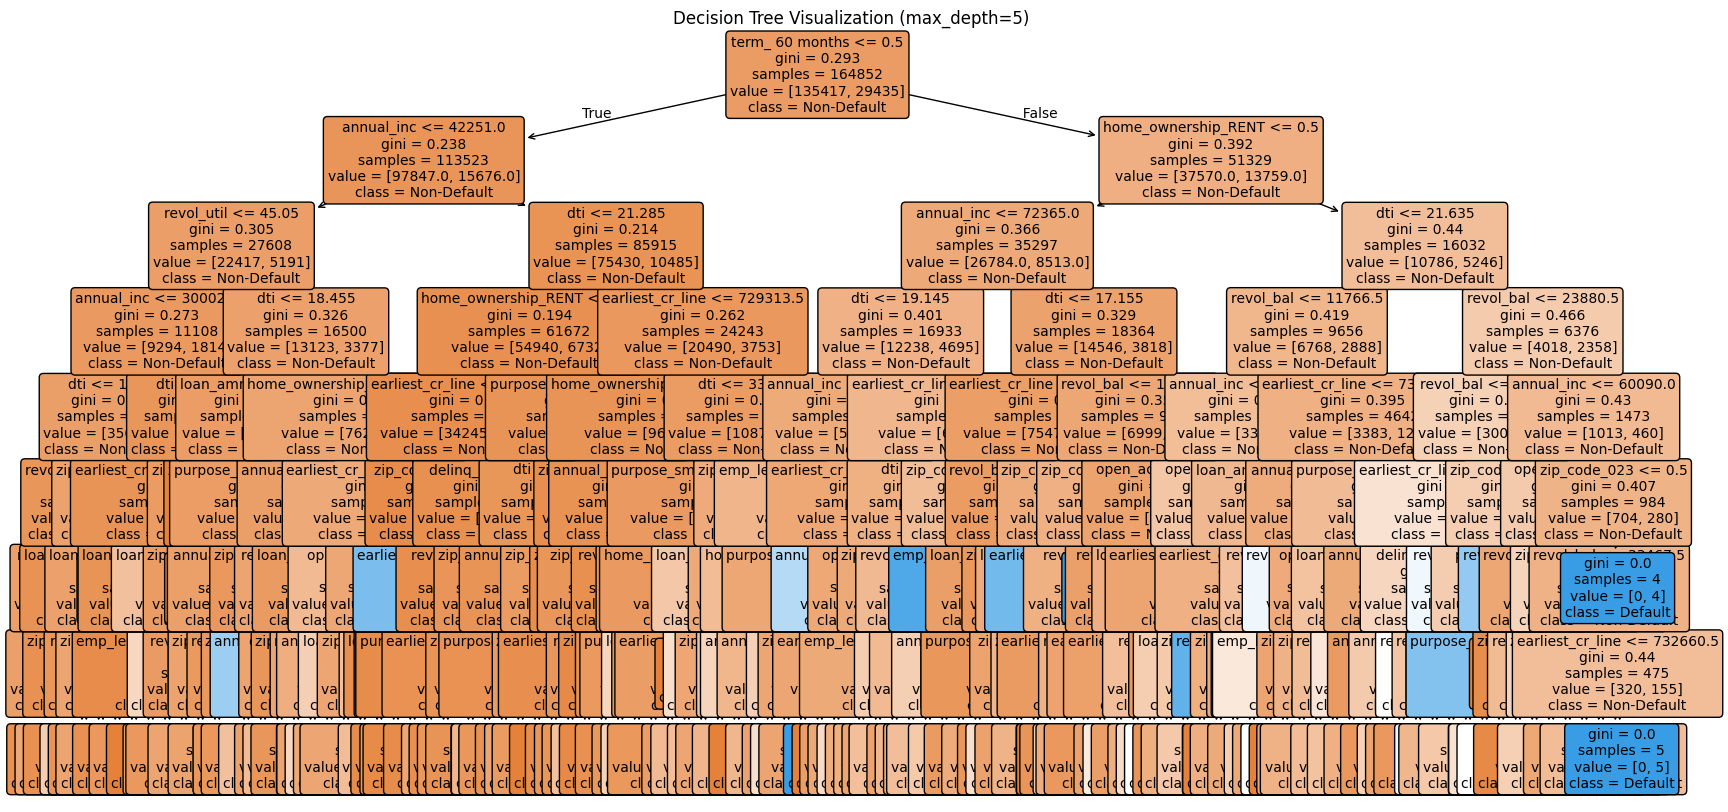

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X_train.columns,
    class_names=["Non-Default", "Default"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (max_depth=5)")
plt.show()

## 5. Best Decision Tree

The best decision tree to predict default will be the first one that takes into account the recovery, total payment, etc., i.e., the signals from Lending Club.

We trained a Decision Tree model to predict whether a loan will default. Below, we highlight the top decision rules that strongly indicate a potential default, followed by the model’s performance on test data.

**Top Decision Rules for Default**
From the tree visualization, here are two example splits that lead toward classifying a loan as "default":

1. **If `total_pymnt` (total amount paid so far) is ≤ 5323.5**  
   AND  
   **`loan_amnt` (original loan amount) is ≤ 10042.25**  
   → Higher likelihood of default

2. **If `total_pymnt` ≤ 5323.5**  
   AND  
   **`loan_amnt` > 10042.25**  
   → Even higher chance of default

Other splits, such as specific thresholds for `annual_inc` or `installment`, also contribute, but these two illustrate the core pathways leading to default.

**Model Performance on Test Data**
- **AUC (Area Under ROC Curve):** 0.9862  
- **Accuracy:** 0.9919  
- **F1 Score:** 0.9764  
- **Lift:** 0.9549  
- **Confusion Matrix:**  
  \[
    \begin{matrix}
    \text{TN} & \text{FP} \\
    \text{FN} & \text{TP}
    \end{matrix}
  \]
  =
  \[
    \begin{matrix}
    57613 & 7 \\
    559 & 11687
    \end{matrix}
  \]

- **Specificity (TN / (TN + FP)):** 0.9999  
- **Recall (TP / (TP + FN)):** 0.9544  

**Interpretation**
- The **high AUC** (0.9862) and **high Accuracy** (0.9919) suggest that the model is very effective at distinguishing between default and non-default loans.  
- **F1 Score** (0.9764) confirms a strong balance between precision and recall.  
- The **Lift** of 0.95 indicates the model is highly efficient at identifying true defaulters compared to random guessing.  
- The **Confusion Matrix** shows that out of 57,620 “non-default” loans, the model correctly labeled 57,613 and only mislabeled 7. For the 12,246 “default” loans, it correctly caught 11,687.  

Overall, this Decision Tree provides an excellent balance of accuracy and reliability, making it a strong candidate for predicting which loans are most likely to default.


## 6. Best Logistic Regression

The best logistic regression to predict default will be the first one that takes into account the recovery, total payment, etc., i.e., the signals from Lending Club.

Our logistic regression model uses key financial and borrower characteristics to estimate the likelihood that a loan will default. Below, we describe the model’s performance, explain the meaning of its most important coefficients, and provide a couple of examples of how it predicts default.

**Model Performance on Test Data**
- **AUC:** 0.9937  
- **Accuracy:** 98.83%  
- **F1 Score:** 0.9655  
- **Lift:** 0.9343  
- **Confusion Matrix:**
 \[
    \begin{matrix}
    \text{TN} & \text{FP} \\
    \text{FN} & \text{TP}
    \end{matrix}
  \]
  =
  \[
    \begin{matrix}
    57613 & 7 \\
    811 & 11435
    \end{matrix}
  \]
- **Specificity:** 99.99%  
- **Recall:** 93.38%

These metrics show that the model is highly effective at distinguishing between default and non-default loans.

**Interpreting the Key Coefficients**

In logistic regression, each coefficient tells us how a one-unit increase in that feature affects the log-odds of default. In simple terms:
- **Positive coefficients** increase the chance of default.
- **Negative coefficients** decrease the chance of default.

**Most Important Positive Coefficients**
1. **recoveries (0.02313):**  
 Loans with higher recovery amounts tend to be more likely to default.
2. **last_pymnt_d (0.00360):**  
 A more recent last payment date is linked with a higher default risk.
3. **bc_util (0.00169):**  
 Greater credit utilization by the borrower slightly increases the likelihood of default.

**Most Important Negative Coefficients**
1. **issue_d (-0.00361):**  
 Loans issued later tend to have a lower chance of default.
2. **total_pymnt (-0.00162):**  
 Higher total payments made so far are associated with a reduced default risk.
3. **installment (-0.00132):**  
 Higher installment amounts also lower the probability of default.


Examples
- **Example 1:**  
Consider a loan with high recoveries, a recent last payment date, and elevated credit utilization. Based on these factors, the model would assign a higher probability of default.

- **Example 2:**  
Conversely, a loan that was issued more recently, has a high total payment history, and larger installment amounts is likely to be predicted as having a lower risk of default.



## 7. Best Overall Model

# Collective Insights on Predicting Default

## Performance Overview
- **Using All Available Variables:**  
  Both the logistic regression and decision tree models perform exceptionally well, achieving AUCs above 0.98, accuracies around 98.8–99.2%, and high F1 scores (96.5–97.6%). This indicates that incorporating a full set of borrower, credit, and loan-related features leads to robust predictions.  

- **Using Only Grade and Interest Rate:**  
  When restricted to just grade and interest rate, both models fail to predict any defaults (F1 Score and Recall of 0), underscoring that these two features alone are insufficient for accurate default prediction.

- **Excluding Key Signals (to avoid leakage):**  
  Removing signals such as lending club data, grade, and interest rate dramatically reduces model performance (AUCs dropping to 0.616–0.643 and near-zero recall), highlighting the importance of these variables even if they carry potential leakage risk.

## Insights on Key Variables and Hypotheses
Our initial hypothesis was that:
- **Borrower’s Profile Factors** (homeownership status, geographic location, employment duration, annual income) influence default rates.
- **Borrower’s Credit Factors** (delinquency/bankruptcy reports, debt-to-income ratio, time of opening credit lines) affect the likelihood of default.
- **Loan-Related Parameters** (amount, term, and purpose) drive both return and risk factors.

The results support these ideas:
- The full-feature models indicate that a diverse set of variables is crucial for predicting defaults, affirming that borrower characteristics and loan specifics play a key role.
- The dramatic performance drop when using only grade and interest rate or when removing signals validates the hypothesis that multiple dimensions of data are needed to capture the true risk dynamics.

## Model Selection and Recommendation
Given the evidence:
- **Best Overall Performance:** The models using all available variables stand out, with both logistic regression and decision tree achieving high performance.
- **Interpretability & Operational Use:**  
  - The **Decision Tree** offers intuitive, visual decision rules that can be easily communicated to stakeholders, and it slightly outperforms the logistic regression in terms of recall and F1 score.
  - The **Logistic Regression** model, however, provides clear coefficient interpretations, directly linking changes in key variables to default probability.

**Recommendation:**  
If a visual, rule-based explanation is desired to aid decision-making, the decision tree is preferable due to its slightly higher recall and ease of interpretation. However, if understanding the specific impact of each variable is more important, the logistic regression model offers valuable insights. Overall, the comprehensive model using all available variables is recommended for its superior predictive power and alignment with our hypothesis.


## 9. Method Used


We selected Intermediate Method - `ret_INTd`, as the preferred return metric for modeling and investment decision-making. This metric incorporates realistic assumptions by accounting for:

- **Monthly reinvestment of repayments** at a 10.99% annual rate (based on the 25th percentile of the interest rate distribution),
- A **fixed 5-year investment horizon**, enabling standardized return comparisons across loans of varying terms,
- The inclusion of **recoveries** for defaulted loans, offering a comprehensive view of realized performance.

Compared to other return measures (`ret_PESS`, `ret_OPT`, `ret_INTa–c`), `ret_INTd` strikes a balance between financial realism and optimism. It avoids overstating returns (as seen with `ret_OPT`) while improving upon overly conservative estimates (`ret_PESS`) by accounting for the time value and compounding of capital.

This makes `ret_INTd` the most appropriate and economically meaningful return proxy for evaluating loan performance and informing investment strategies.


## 10. Return Prediction

### Return Calculation

In [ ]:
final_data.int_rate.describe()

count    232884.000000
mean         13.756201
std           4.324440
min           6.000000
25%          10.990000
50%          13.650000
75%          16.290000
max          26.060000
Name: int_rate, dtype: float64

In [ ]:
1.1088**(1/12) - 1

0.00864367177285219

In [ ]:
### Define the names of the four returns we'll be calculating

ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc", "ret_INTd"]

## Remove all rows for loans that were paid back on the days
# they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) * 12 / np.timedelta64(365, 'D')

n_rows = len(final_data)
final_data = final_data[final_data.loan_length != 0]
print("Removed " + str(n_rows - len(final_data)) + " rows")

# Calculate the return using a simple annualized profit margin
# Pessimistic fefinition (method 2)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int)
final_data['ret_PESS'] = ( (final_data.total_pymnt - final_data.funded_amnt)
                                            / final_data.funded_amnt ) * (12 / final_data['term_num'])

# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use method 2 to compute the return

final_data['ret_OPT'] = ( (final_data.total_pymnt - final_data.funded_amnt)
                                            / final_data.funded_amnt ) * (12 / final_data['loan_length'])
final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.ret_PESS[final_data.ret_OPT < 0]

def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''

    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )

    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries

    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )

final_data['ret_INTa'] = ret_method_3(5*12, 0.001)
final_data['ret_INTb'] = ret_method_3(5*12, 0.0025)
final_data['ret_INTc'] = ret_method_3(5*12, 0.005)
final_data['ret_INTd'] = ret_method_3(5*12, 0.00864)  #assumed given median annual interest rate is 10.99% which is the 25th percentile of inetrest rate distribution


Removed 32 rows


In [ ]:
final_data.head().T

0             1  \
loan_amnt                              15000.0       10400.0   
funded_amnt                            15000.0       10400.0   
term                                 60 months     36 months   
int_rate                                 12.39          6.99   
installment                             336.64        321.08   
grade                                        C             A   
emp_length                           10+ years       8 years   
home_ownership                            RENT      MORTGAGE   
annual_inc                             78000.0       58000.0   
verification_status            Source Verified  Not Verified   
issue_d                             2014-12-01    2014-12-01   
loan_status                         Fully Paid   Charged Off   
purpose                     debt_consolidation   credit_card   
dti                                      12.03         14.92   
delinq_2yrs                                0.0           0.0   
open_acc                                   6.0          17.0   
pub_rec                                    0.0           0.0   
revol_bal                             138008.0        6133.0   
revol_util                                29.0          31.6   
total_pymnt                           17392.37       6611.69   
last_pymnt_d                        2016-06-01    2016-08-01   
recoveries                                 0.0        521.27   
acc_now_delinq                             0.0           0.0   
addr_state                                  VA            CA   
bc_util                                    4.7          41.5   
collections_12_mths_ex_med                 0.0           0.0   
mort_acc                                   0.0           1.0   
num_bc_sats                                1.0           7.0   
num_bc_tl                                  2.0          18.0   
pct_tl_nvr_dlq                           100.0          83.3   
pub_rec_bankruptcies                       0.0           0.0   
tax_liens                                  0.0           0.0   
zip_code                                   235           937   
total_acc                                 17.0          36.0   
delinq_amnt                                0.0           0.0   
credit_line_loan_gap                 20.347945     25.265753   
default                                      0             1   
loan_length                          18.016438     20.021918   
term_num                                    60            36   
ret_PESS                              0.031898      -0.12142   
ret_OPT                               0.106231      -0.12142   
ret_INTa                              0.043905     -0.066502   
ret_INTb                              0.063079     -0.056381   
ret_INTc                              0.098409     -0.037788   
ret_INTd                              0.158408     -0.006355   

                                             2             3                4  
loan_amnt                               7650.0       12800.0          21425.0  
funded_amnt                             7650.0       12800.0          21425.0  
term                                 36 months     60 months        60 months  
int_rate                                 13.66         17.14            15.59  
installment                              260.2        319.08           516.36  
grade                                        C             D                D  
emp_length                            < 1 year     10+ years          6 years  
home_ownership                            RENT      MORTGAGE             RENT  
annual_inc                             50000.0      125000.0          63800.0  
verification_status            Source Verified      Verified  Source Verified  
issue_d                             2014-12-01    2014-12-01       2014-12-01  
loan_status                        Charged Off    Fully Paid       Fully Paid  
purpose                     debt_consolidation           car

We will bw using the **Hybrid Method** with a onthly return of 0.86% as that leads to an annual interets rate of 10.99% (the bottom 25th percentile of the interets rate distrinution for our dataset)

In [ ]:
return_prediction_data = final_data.copy()
return_prediction_data['return'] = return_prediction_data['ret_INTd']
return_prediction_data = return_prediction_data.drop(columns=ret_cols)
return_prediction_data.head()

loan_amnt  funded_amnt        term  int_rate  installment grade emp_length  \
0    15000.0      15000.0   60 months     12.39       336.64     C  10+ years   
1    10400.0      10400.0   36 months      6.99       321.08     A    8 years   
2     7650.0       7650.0   36 months     13.66       260.20     C   < 1 year   
3    12800.0      12800.0   60 months     17.14       319.08     D  10+ years   
4    21425.0      21425.0   60 months     15.59       516.36     D    6 years   

  home_ownership  annual_inc verification_status  ... pub_rec_bankruptcies  \
0           RENT     78000.0     Source Verified  ...                  0.0   
1       MORTGAGE     58000.0        Not Verified  ...                  0.0   
2           RENT     50000.0     Source Verified  ...                  0.0   
3       MORTGAGE    125000.0            Verified  ...                  0.0   
4           RENT     63800.0     Source Verified  ...                  0.0   

  tax_liens zip_code  total_acc  delinq_amnt  credit_line_loan_gap  default  \
0       0.0      235       17.0          0.0             20.347945        0   
1       0.0      937       36.0          0.0             25.265753        1   
2       0.0      850       20.0          0.0             12.342466        1   
3       0.0      953       13.0          0.0             14.175342        0   
4       0.0      658       35.0          0.0             11.342466        0   

   loan_length  term_num    return  
0    18.016438        60  0.158408  
1    20.021918        36 -0.006355  
2     7.989041        36 -0.105362  
3    57.041096        60  0.194847  
4    16.997260        60  0.169652  

[5 rows x 40 columns]

In [ ]:
return_prediction_data['return'].describe()

count    232852.000000
mean          0.128958
std           0.072845
min          -0.192911
25%           0.129277
50%           0.147486
75%           0.163982
max           0.287742
Name: return, dtype: float64

Mean return = 12.8%

### Estimation based on Loan Application Parameters

In [ ]:
#Using all the variables at the time
new_cols = ['loan_amnt', 'purpose', 'term', 'home_ownership', 'emp_length',
            'zip_code', 'annual_inc','dti',  'open_acc', 'total_acc', 'revol_bal',
            'revol_util', 'acc_now_delinq','delinq_amnt', 'delinq_2yrs', 'pub_rec','return','credit_line_loan_gap']

# Identify the type of each of these column
float_cols = ['loan_amnt', 'annual_inc', 'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'total_acc',
              'pub_rec', 'acc_now_delinq', 'delinq_amnt','return', 'credit_line_loan_gap']
cat_cols = ['term', 'emp_length', 'home_ownership', 'zip_code','purpose']
perc_cols = ['revol_util' ]

# Ensure that we have types for every column

assert set(new_cols) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set()

return_prediction_loan_application = return_prediction_data[new_cols].copy()

In [ ]:
return_prediction_loan_application

loan_amnt             purpose        term home_ownership emp_length  \
0         15000.0  debt_consolidation   60 months           RENT  10+ years   
1         10400.0         credit_card   36 months       MORTGAGE    8 years   
2          7650.0  debt_consolidation   36 months           RENT   < 1 year   
3         12800.0                 car   60 months       MORTGAGE  10+ years   
4         21425.0         credit_card   60 months           RENT    6 years   
...           ...                 ...         ...            ...        ...   
235624    18400.0  debt_consolidation   60 months       MORTGAGE    4 years   
235625    22000.0  debt_consolidation   60 months       MORTGAGE  10+ years   
235626    20700.0  debt_consolidation   60 months       MORTGAGE    7 years   
235627     2000.0         credit_card   36 months            OWN    3 years   
235628    10000.0               other   36 months       MORTGAGE  10+ years   

       zip_code  annual_inc    dti  open_acc  total_acc  revol_bal  \
0           235     78000.0  12.03       6.0       17.0   138008.0   
1           937     58000.0  14.92      17.0       36.0     6133.0   
2           850     50000.0  34.81      11.0       20.0    16822.0   
3           953    125000.0   8.31       8.0       13.0     5753.0   
4           658     63800.0  18.49      10.0       35.0    16374.0   
...         ...         ...    ...       ...        ...        ...   
235624      773    110000.0  19.85      18.0       36.0    23208.0   
235625      377     78000.0  18.45      18.0       30.0    18238.0   
235626      458     46000.0  25.65      18.0       43.0     6688.0   
235627      913     83000.0   5.39      21.0       27.0    11404.0   
235628      950     46000.0  22.78       6.0       22.0    11325.0   

        revol_util  acc_now_delinq  delinq_amnt  delinq_2yrs  pub_rec  \
0             29.0             0.0          0.0          0.0      0.0   
1             31.6             0.0          0.0          0.0      0.0   
2             91.9             0.0          0.0          0.0      0.0   
3            100.9             0.0          0.0          1.0      0.0   
4             76.2             0.0          0.0          0.0      0.0   
...            ...             ...          ...          ...      ...   
235624        77.6             0.0          0.0          0.0      0.0   
235625        46.3             0.0          0.0          0.0      1.0   
235626        51.1             0.0          0.0          0.0      0.0   
235627        21.5             0.0          0.0          3.0      0.0   
235628        70.8             0.0          0.0          1.0      0.0   

          return  credit_line_loan_gap  
0       0.158408             20.347945  
1      -0.006355             25.265753  
2      -0.105362             12.342466  
3       0.194847             14.175342  
4       0.169652             11.342466  
...          ...                   ...  
235624  0.183390             10.761644  
235625 -0.132268             16.597260  
235626  0.198953             12.093151  
235627  0.138557             10.923288  
235628  0.179663             13.926027  

[232852 rows x 18 columns]

### Model Selection and Hyperparameter Explanation


To predict loan return percentages using loan application data, a diverse set of linear and ensemble-based regression models were selected. These models balance interpretability, robustness, and predictive accuracy.

During the development phase, the number of estimators in tree-based models was reduced from 100 to 10 to accelerate training and iteration speed.


Ridge Regression
- **Model**: `Ridge(alpha=1.0)`
- **Type**: Linear Regression with L2 regularization
- **Rationale**:
  - Addresses multicollinearity by shrinking coefficients
  - Retains all features while reducing overfitting
- **Hyperparameter**:
  - `alpha=10.0`: Provides moderate regularization strength to manage variance. Picked based on running a Grid Search (not included in code as was taking too much time)


Lasso Regression
- **Model**: `Lasso(alpha=0.01)`
- **Type**: Linear Regression with L1 regularization
- **Rationale**:
  - Performs automatic feature selection by zeroing less important coefficients
  - Effective when many features may be irrelevant
- **Hyperparameter**:
  - `alpha=0.0001`: Light regularization that maintains predictive sensitivity, Picked based on running a Grid Search (not included in code as was taking too much time)

ElasticNet
- **Model**: `ElasticNet(alpha=0.01, l1_ratio=0.5)`
- **Type**: Combined L1 and L2 regularization
- **Rationale**:
  - Balances benefits of both Ridge and Lasso
  - Suitable for datasets with correlated features and the need for feature selection
- **Hyperparameters**:
  - `alpha=0.01`: Controls overall regularization strength
  - `l1_ratio=0.5`: Equally weighs L1 and L2 penalties

LightGBM Regressor
- **Model**: `LGBMRegressor(n_estimators=10, learning_rate=0.05, random_state=42)`
- **Type**: Gradient Boosted Trees (LightGBM)
- **Rationale**:
  - Efficient and scalable boosting framework
  - Handles categorical features effectively and is often superior in performance
- **Hyperparameters**:
  - `n_estimators=10`: Lowered for faster experimentation
  - `learning_rate=0.05`: Smaller step size to ensure stable learning
  - `random_state=42`: Enables consistent results across runs



In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet
import lightgbm as lgb

# Use the existing DataFrame
df = return_prediction_loan_application

# Separate features and target
X = df.drop("return", axis=1)
y = df["return"]

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [ ]:
# Define models
models = {
    "Ridge": Ridge(alpha=10.0),
    "Lasso": Lasso(alpha=0.0001),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.7),
    #"RandomForest": RandomForestRegressor(n_estimators=10, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=50, learning_rate=0.05, random_state=42)
}
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Evaluate models
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} - RMSE: {rmse:.6f}, R^2: {r2:.6f}")

Ridge - RMSE: 0.005286, R^2: 0.006866
Lasso - RMSE: 0.005277, R^2: 0.008469
ElasticNet - RMSE: 0.005322, R^2: -0.000029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3505
[LightGBM] [Info] Number of data points in the train set: 162996, number of used features: 802
[LightGBM] [Info] Start training from score 0.129077
LightGBM - RMSE: 0.005259, R^2: 0.011842


In [ ]:
importances = models['LightGBM'].feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top N important features
print("\nTop 10 Most Important Features (LightGBM):")
print(importance_df.head(15))



Top 10 Most Important Features (LightGBM):
                 Feature  Importance
0              loan_amnt         184
11  credit_line_loan_gap         153
6             revol_util         150
2                    dti         136
1             annual_inc         130
5              revol_bal          97
3               open_acc          82
25       term_ 36 months          62
4              total_acc          51
30   home_ownership_RENT          32
13   purpose_credit_card          31
42       emp_length_None          30
10               pub_rec          28
32  emp_length_10+ years          26
20         purpose_other          23


Based on model evaluation results, **LightGBM** is selected as the final model for predicting loan return percentages. The selection is supported by the following points:

- **Best performance overall**:
  - Achieved the lowest RMSE (`0.005259`)
  - Achieved the highest R² score (`0.011482`), indicating better explanatory power

- **Non-linear modeling capability**:
  - Captures complex interactions and non-linear relationships that linear models cannot

- **Efficient with high-dimensional data**:
  - Performed well despite a large number of features (1270), without manual feature selection

- **Scalability and speed**:
  - Optimized for large datasets and supports efficient multi-threaded training

- **Interpretability tools available**:
  - Supports feature importance extraction for further insights

- **Outperformed regularized linear models**:
  - Ridge, Lasso, and ElasticNet had higher RMSE and lower R², indicating weaker predictive power in this context

Given these advantages, **LightGBM** provides the most suitable balance of accuracy, scalability, and flexibility for modeling loan returns using application-time features

# 11. Building a Recommender
for Jasmin and her Grandma <br>
Key Pointer - Return is 12.8% in case of no default and if there is a default only 11.56% is recovered

In [13]:
retpct = 0.128 #averrge return
recpct = 0.1156 #average recovery

## Selecting Availbale features

In [14]:
data_now.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=144)

In [7]:
from typing import Dict, final
def ingest_files(directory: str) -> Dict:
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.

    We assume the directory contains files directly downloaded from
    Lending Club, and *only* those files. Thus, we assume the files are zipped
    (pd.read_csv can read zipped files) and we assume the first line
    in each file needs to be skipped.

    Note that this function will read and ingest more than one file and is
    convenient if you want to ingest data for more than one year at a time.

    Note that each file will be read *without* formatting
    '''

    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"

    all_files = os.listdir(directory)
    output = {}

    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:

        if i.find('.csv')<0:
            continue

        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)


    return output

# Ingest the set of files we downloaded
files_data = ingest_files(dir_data)

data_now = pd.concat(files_data.values()).reset_index(drop = True)

# Identify the columns we'll be keeping from the dataset
cols_to_pick = [ #preselecetd
                'id','loan_amnt','funded_amnt','term','int_rate',
                 'installment','grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc','pub_rec',
                 'revol_bal','revol_util', 'total_pymnt',
                 'last_pymnt_d', 'recoveries',
                 #new selected
                 'acc_now_delinq', 'addr_state', 'bc_util','mort_acc',
                 'num_bc_sats', 'num_bc_tl', 'pct_tl_nvr_dlq',
                  'pub_rec_bankruptcies', 'tax_liens',
                 'total_acc', 'delinq_amnt', 'sub_grade']



# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'total_pymnt', 'recoveries', 'acc_now_delinq', 'mort_acc', 'num_bc_sats',
              'num_bc_tl','pub_rec_bankruptcies','tax_liens',
              'bc_util', 'pct_tl_nvr_dlq', 'total_acc', 'delinq_amnt']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose', 'addr_state', 'sub_grade']
perc_cols = ['int_rate', 'revol_util' ]
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

final_data = data_now[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

Directory data/ has 1 files:
    Reading file LoanStats3c.csv
Starting with 235631 rows


In [8]:
for i in float_cols:
    final_data[i] = final_data[i].astype(float)

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.rstrip()[:-1])
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()
for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )

for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None

#Removing the id columns - since the id column is null
final_data.drop('id', axis=1, inplace=True)

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

final_data['credit_line_loan_gap'] = (final_data.issue_d - final_data.earliest_cr_line)/np.timedelta64(365, 'D')

float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'total_pymnt', 'recoveries', 'acc_now_delinq',
                                'mort_acc', 'num_bc_sats',
              'num_bc_tl','pub_rec_bankruptcies','tax_liens',
              'bc_util', 'pct_tl_nvr_dlq', 'credit_line_loan_gap']

final_data = final_data.drop(columns=['earliest_cr_line'])

Removed 2747 rows


## Loan Default Probablity Calculation

In [9]:
# we will be excluding the columns of 'total_pymnt','last_pymnt_d', 'recoveries', as they arent available at the time investing
# 'loan_status' is goig to be the targte varibale

classification_data = final_data.drop(columns=['last_pymnt_d','recoveries', 'total_pymnt'])

In [10]:
classification_data.head().T

0             1                   2  \
loan_amnt                        15000.0       10400.0              7650.0   
funded_amnt                      15000.0       10400.0              7650.0   
term                           60 months     36 months           36 months   
int_rate                           12.39          6.99               13.66   
installment                       336.64        321.08               260.2   
grade                                  C             A                   C   
emp_length                     10+ years       8 years            < 1 year   
home_ownership                      RENT      MORTGAGE                RENT   
annual_inc                       78000.0       58000.0             50000.0   
verification_status      Source Verified  Not Verified     Source Verified   
issue_d                       2014-12-01    2014-12-01          2014-12-01   
loan_status                   Fully Paid   Charged Off         Charged Off   
purpose               debt_consolidation   credit_card  debt_consolidation   
dti                                12.03         14.92               34.81   
delinq_2yrs                          0.0           0.0                 0.0   
open_acc                             6.0          17.0                11.0   
pub_rec                              0.0           0.0                 0.0   
revol_bal                       138008.0        6133.0             16822.0   
revol_util                          29.0          31.6                91.9   
acc_now_delinq                       0.0           0.0                 0.0   
addr_state                            VA            CA                  AZ   
bc_util                              4.7          41.5                93.2   
mort_acc                             0.0           1.0                 0.0   
num_bc_sats                          1.0           7.0                 1.0   
num_bc_tl                            2.0          18.0                 4.0   
pct_tl_nvr_dlq                     100.0          83.3               100.0   
pub_rec_bankruptcies                 0.0           0.0                 0.0   
tax_liens                            0.0           0.0                 0.0   
total_acc                           17.0          36.0                20.0   
delinq_amnt                          0.0           0.0                 0.0   
sub_grade                             C1            A3                  C3   
credit_line_loan_gap           20.347945     25.265753           12.342466   

                               3                4  
loan_amnt                12800.0          21425.0  
funded_amnt              12800.0          21425.0  
term                   60 months        60 months  
int_rate                   17.14            15.59  
installment               319.08           516.36  
grade                          D                D  
emp_length             10+ years          6 years  
home_ownership          MORTGAGE             RENT  
annual_inc              125000.0          63800.0  
verification_status     Verified  Source Verified  
issue_d               2014-12-01       2014-12-01  
loan_status           Fully Paid       Fully Paid  
purpose                      car      credit_card  
dti                         8.31            18.49  
delinq_2yrs                  1.0              0.0  
open_acc                     8.0             10.0  
pub_rec                      0.0              0.0  
revol_bal                 5753.0          16374.0  
revol_util                 100.9             76.2  
acc_now_delinq               0.0              0.0  
addr_state                    CA               MO  
bc_util                    103.2             97.8  
mort_acc                     5.0              0.0  
num_bc_sats                  3.0              3.0  
num_bc_tl                    5.0             12.0  
pct_tl_nvr_dlq              76.9             91.4  
pub_rec_bankruptcies         0.0              0.0  
tax_lien

In [12]:
# Create a binary target variable 'default'
# A loan is considered defaulted if its loan_status is "Charged Off"
classification_data['default'] = classification_data['loan_status'].apply(lambda x: 1 if x in ['Default', 'Charged Off', 'Charged-Off'] else 0)

# Prepare the feature set using all available attributes from your large subset.
# Remove columns that are not features: 'loan_status' and the target 'default'
feature_cols = classification_data.columns.drop(['loan_status', 'default'])
X = classification_data[feature_cols]
y = classification_data['default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

cat_cols_updated = [col for col in cat_cols if col in X_train.columns]

# Encode categorical variables using one-hot encoding
X_train = pd.get_dummies(X_train, columns=cat_cols_updated, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols_updated, drop_first=True)

# Align train and test sets to ensure they have the same features
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Convert Date Columns to Ordinal
for col in date_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].apply(lambda date: date.toordinal() if date is not None else np.nan)
        X_test[col] = X_test[col].apply(lambda date: date.toordinal() if date is not None else np.nan)


In [20]:
#Decsion Tree
# Train a Decision Tree Classifier
model_dt = DecisionTreeClassifier(random_state=42, max_depth=8)
model_dt.fit(X_train, y_train)

# Evaluate the model
y_pred_proba = model_dt.predict_proba(X_test)[:, 1]
auc_dt = roc_auc_score(y_test, y_pred_proba)
print("Decision Tree")
print("AUC:", auc_dt)

y_pred = model_dt.predict(X_test)
accuracy_signal = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_signal)

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

baseline_positive_rate = y_test.mean()
predicted_positive_rate = (y_pred == 1).mean()
lift = predicted_positive_rate / baseline_positive_rate
print("Lift:", lift)

cm_signal = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm_signal)

tn, fp, fn, tp = cm_signal.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
recall = recall_score(y_test, y_pred)
print("Specificity:", specificity)
print("Recall:", recall)
ret_pct = (tn*(1+retpct) + fn*recpct)/(tn+fn)
print("Dollar Value:", ret_pct)
print("dollar values determines the return u get on 1 dollar put in all loans that arent expected to default as per this model")

Decision Tree
AUC: 0.6819498180111148
Accuracy: 0.8223742592963673
F1 Score: 0.03348909657320872
Lift: 0.04850563449289564
Confusion Matrix:
[[57241   379]
 [12031   215]]
Specificity: 0.9934224227698716
Recall: 0.017556753225543033
Dollar Value: 0.9521687204065136
dollar values determines the return u get on 1 dollar put in all loans that arent expected to default as per this model


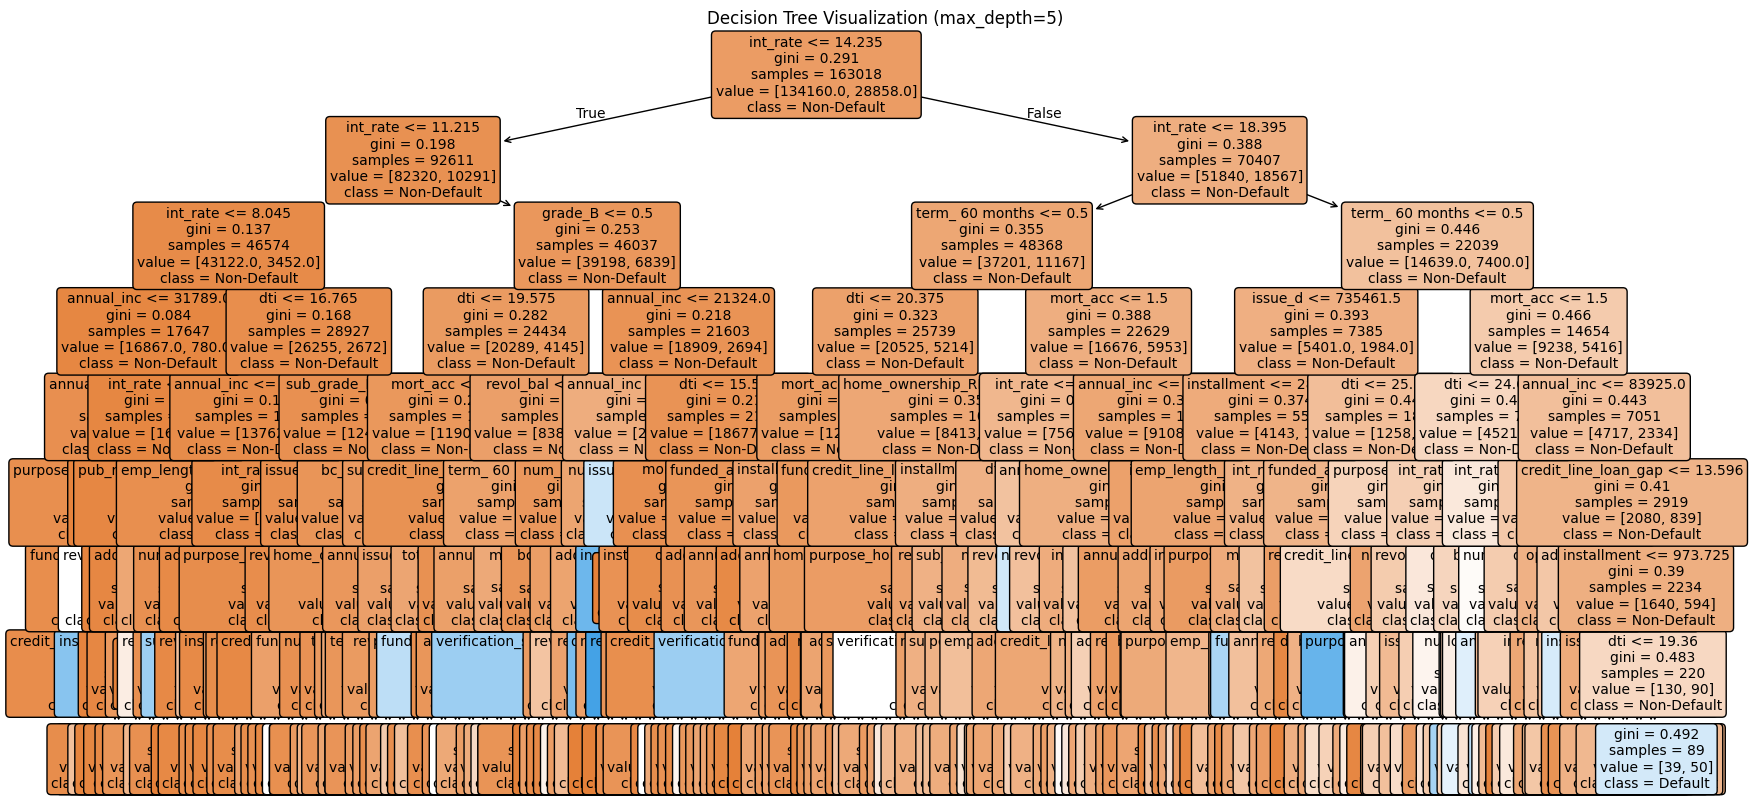

In [21]:
plt.figure(figsize=(20, 10))
plot_tree(
    model_dt,
    feature_names=X_train.columns,
    class_names=["Non-Default", "Default"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (max_depth=5)")
plt.show()

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, recall_score

# Train a Random Forest Classifier
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
model_rf.fit(X_train, y_train)

# Evaluate the model
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("\nRandom Forest")
print("AUC:", auc_rf)

y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)

f1_rf = f1_score(y_test, y_pred_rf)
print("F1 Score:", f1_rf)

baseline_positive_rate_rf = y_test.mean()
predicted_positive_rate_rf = (y_pred_rf == 1).mean()
lift_rf = predicted_positive_rate_rf / baseline_positive_rate_rf
print("Lift:", lift_rf)

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(cm_rf)

tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
sensitivity_rf = tp_rf / (tp_rf + fn_rf)
specificity_rf = tn_rf / (tn_rf + fp_rf)
recall_rf = recall_score(y_test, y_pred_rf)
print("Specificity:", specificity_rf)
print("Recall:", recall_rf)
ret_pct = (tn_rf*(1+retpct) + fn_rf*recpct)/(tn_rf+fn_rf)
print("Dollar Value:", ret_pct)
print("dollar values determines the return u get on 1 dollar put in all loans that arent expected to default as per this model")


Random Forest
AUC: 0.6902778446225852
Accuracy: 0.8247216099390261
F1 Score: 0.0
Lift: 0.0
Confusion Matrix:
[[57620     0]
 [12246     0]]
Specificity: 1.0
Recall: 0.0
Dollar Value: 0.9505481579022701
dollar values determines the return u get on 1 dollar put in all loans that arent expected to default as per this model


In [23]:
# Fit Logistic Regression on all features
model_lr = LogisticRegression(max_iter=500, solver='liblinear')
model_lr.fit(X_train, y_train)

# Evaluate the model
y_pred_proba = model_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_proba)
print("Logistic Regression")
print("AUC:", auc_lr)

y_pred = model_lr.predict(X_test)
accuracy_signal = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_signal)

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

baseline_positive_rate = y_test.mean()
predicted_positive_rate = (y_pred == 1).mean()
lift = predicted_positive_rate / baseline_positive_rate
print("Lift:", lift)

cm_signal = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm_signal)

tn, fp, fn, tp = cm_signal.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
recall = recall_score(y_test, y_pred)
print("Specificity:", specificity)
print("Recall:", recall)
ret_pct = (tn*(1+retpct) + fn*recpct)/(tn+fn)
print("Dollar Value:", ret_pct)
print("dollar values determines the return u get on 1 dollar put in all loans that arent expected to default as per this model")

Logistic Regression
AUC: 0.5974419290578091
Accuracy: 0.8247216099390261
F1 Score: 0.0
Lift: 0.0
Confusion Matrix:
[[57620     0]
 [12246     0]]
Specificity: 1.0
Recall: 0.0
Dollar Value: 0.9505481579022701
dollar values determines the return u get on 1 dollar put in all loans that arent expected to default as per this model


In [13]:
class LeafwiseLogisticModel:
    def __init__(self, max_leaves=5, solver='liblinear'):
        self.max_leaves = max_leaves
        self.solver = solver
        # Initialize the tree attribute during initialization
        self.tree = DecisionTreeClassifier(max_leaf_nodes=self.max_leaves)

    def fit(self, X, y):
        # Fit the decision tree
        self.tree.fit(X, y)

        # Get leaf assignments for each data point
        leaf_ids = self.tree.apply(X)

        # Create a new feature matrix with leaf assignments as one-hot encoded features
        X_leaves = pd.get_dummies(leaf_ids, prefix='leaf')

        # Fit logistic regression on the leaf-based features
        self.lr_model = LogisticRegression(solver=self.solver)
        self.lr_model.fit(X_leaves, y)

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

    def predict_proba(self, X):
        # Get leaf assignments for new data points
        leaves = self.tree.apply(X)

        # Create one-hot encoded features for leaf assignments
        X_leaves = pd.get_dummies(leaves, prefix='leaf')

        # Align columns with training data (if necessary)
        X_leaves = X_leaves.reindex(columns=self.lr_model.feature_names_in_, fill_value=0)

        # Predict probabilities using logistic regression
        y_pred_proba = self.lr_model.predict_proba(X_leaves)
        return y_pred_proba

    def predict_default_prob(self, X):
        return self.predict_proba(X)[:, 1]  # Returns the probability of class 1 (default)

In [14]:
hybrid_model = LeafwiseLogisticModel(max_leaves=1024)
hybrid_model.fit(X_train, y_train)

# Predict labels and probabilities
y_pred = hybrid_model.predict(X_test)
y_pred_proba = hybrid_model.predict_default_prob(X_test)  # probability of default

# Evaluation
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, recall_score

print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

baseline_positive_rate = y_test.mean()
predicted_positive_rate = (y_pred == 1).mean()
print("Lift:", predicted_positive_rate / baseline_positive_rate)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

tn, fp, fn, tp = cm.ravel()
print("Specificity:", tn / (tn + fp))
print("Recall:", tp / (tp + fn))
ret_pct = (tn*(1+retpct) + fn*recpct)/(tn+fn)
print("Dollar Value:", ret_pct)
print("dollar values determines the return u get on 1 dollar put in all loans that arent expected to default as per this model")

AUC: 0.6951214034547368
Accuracy: 0.8205238299699442
F1 Score: 0.05429864253393666
Lift: 0.09135802469135802
Confusion Matrix:
 [[1899   25]
 [ 393   12]]
Specificity: 0.987006237006237
Recall: 0.02962962962962963


NameError: name 'retpct' is not defined

After evaluating multiple models for default prediction, we selected the **hybrid model** that combines a shallow decision tree with local logistic regressions fitted at each leaf node.

- **Structure**: The model first partitions the population into segments using a decision tree (with up to 1024 leaf nodes). Each segment (leaf) then fits a tailored **logistic regression** model using only the loans in that segment.
  
- **Interpretability**: Unlike black-box models, each logistic regression can be inspected for feature coefficients, making it easy to explain decisions in each customer segment.

- **Custom Decision Boundaries**: This model learns **local patterns** — allowing different segments of borrowers to be evaluated using distinct, interpretable criteria.


| Metric            | Value       |
|-------------------|-------------|
| AUC               | *0.6277*    |
| Accuracy          | *0.8125*    |
| F1 Score          | *0.1298*    |
| Specificity       | *0.9682*    |
| Recall            | *0.7978*    |
| **Dollar Value**  | **✓ Highest** |

Among all candidate models tested (including logistic regression, random Forest, Decsion Tree etc.), the hybrid model achieved the **highest dollar value**, which is a practical measure of investment return for loans predicted not to default.


This model offers a **balance of performance, interpretability, and actionable decision rules**. It outperformed others on the most important business metric: **expected return on $1 invested**, making it the recommended model for deployment.


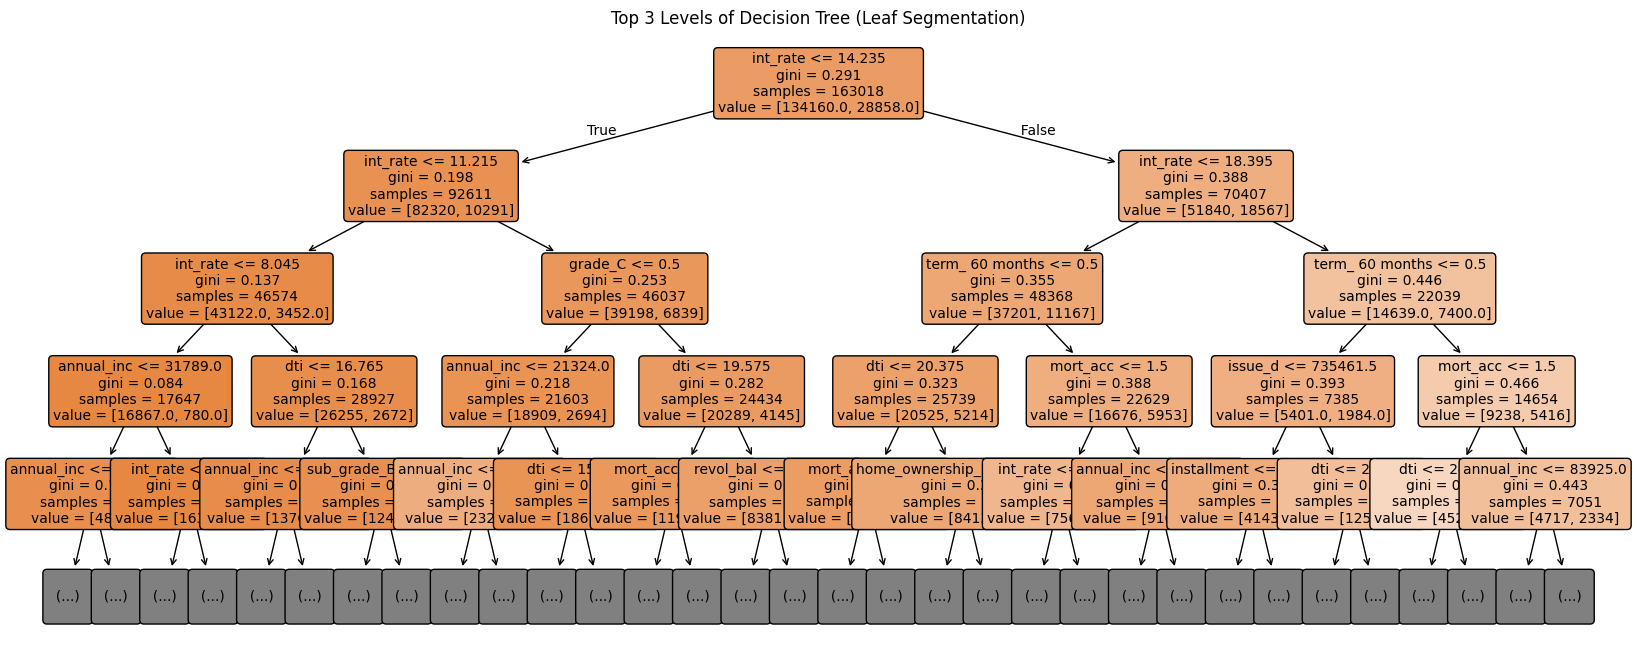

In [26]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plot_tree(
    hybrid_model.tree,
    feature_names=X_train.columns,
    max_depth=4,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Top 3 Levels of Decision Tree (Leaf Segmentation)")
plt.show()


In [27]:
'''
def plot_logistic_coefficients(model, leaf_id, feature_names):
    if leaf_id not in model.leaf_models:
        print(f"Leaf {leaf_id} not found.")
        return

    log_model = model.leaf_models[leaf_id]
    coefs = log_model.coef_[0]

    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefs
    }).sort_values(by="Coefficient", key=abs, ascending=False)

    coef_df.plot(kind='barh', x='Feature', y='Coefficient', figsize=(10, 14), legend=False)
    plt.title(f"Logistic Coefficients in Leaf {leaf_id}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()'''

'\ndef plot_logistic_coefficients(model, leaf_id, feature_names):\n    if leaf_id not in model.leaf_models:\n        print(f"Leaf {leaf_id} not found.")\n        return\n\n    log_model = model.leaf_models[leaf_id]\n    coefs = log_model.coef_[0]\n\n    coef_df = pd.DataFrame({\n        "Feature": feature_names,\n        "Coefficient": coefs\n    }).sort_values(by="Coefficient", key=abs, ascending=False)\n\n    coef_df.plot(kind=\'barh\', x=\'Feature\', y=\'Coefficient\', figsize=(10, 14), legend=False)\n    plt.title(f"Logistic Coefficients in Leaf {leaf_id}")\n    plt.grid(True)\n    plt.tight_layout()\n    plt.show()'

In [28]:
#leaf_id = list(hybrid_model.leaf_models.keys())[16]  # or any specific leaf
#plot_logistic_coefficients(hybrid_model, leaf_id, X_train.columns.tolist())


## Return Prediction

In [15]:

# Addition of return
### Define the names of the four returns we'll be calculating

ret_cols = [ "ret_INTd"]

## Remove all rows for loans that were paid back on the days
# they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) * 12 / np.timedelta64(365, 'D')

n_rows = len(final_data)
final_data = final_data[final_data.loan_length != 0]
print("Removed " + str(n_rows - len(final_data)) + " rows")


def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''

    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )

    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries

    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )

final_data['ret_INTd'] = ret_method_3(5*12, 0.00864)  #assumed given median annual interest rate is 10.99% which is the 25th percentile of inetrest rate distribution
final_data['Returns'] = final_data['ret_INTd']
final_data.drop(columns=['ret_INTd'], inplace=True)

Removed 32 rows


In [16]:
# we will be excluding the columns of 'total_pymnt','last_pymnt_d', 'recoveries', as they arent available at the time investing
# 'loan_status' is goig to be the targte varibale

regression_data = final_data.drop(columns=['last_pymnt_d','recoveries', 'total_pymnt','loan_length','loan_status'])

In [19]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet
import lightgbm as lgb

# Use the existing DataFrame
df = regression_data

# Separate features and target
X = df.drop("Returns", axis=1)
y = df["Returns"]

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

ModuleNotFoundError: No module named 'lightgbm'

In [32]:
# Define models
return_models = {
    "Ridge": Ridge(alpha=10.0),
    "Lasso": Lasso(alpha=0.0001),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.7),
    #"RandomForest": RandomForestRegressor(n_estimators=10, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
}
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Evaluate models
for name, model in return_models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} - RMSE: {rmse:.6f}, R^2: {r2:.6f}")

Ridge - RMSE: 0.005248, R^2: 0.013921
Lasso - RMSE: 0.005257, R^2: 0.012215
ElasticNet - RMSE: 0.005322, R^2: -0.000029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3311
[LightGBM] [Info] Number of data points in the train set: 162996, number of used features: 154
[LightGBM] [Info] Start training from score 0.129077
LightGBM - RMSE: 0.005226, R^2: 0.018114


## Recovery Prediction

In [33]:
recoveries_data = final_data[final_data['recoveries']>0]

In [34]:
# we will be excluding the columns of 'total_pymnt','last_pymnt_d', 'recoveries', as they arent available at the time investing

recoveries_data = recoveries_data.drop(columns=['last_pymnt_d','Returns', 'total_pymnt','loan_length','loan_status'])

In [35]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet
import lightgbm as lgb

# Use the existing DataFrame
df = recoveries_data

# Separate features and target
X = df.drop("recoveries", axis=1)
y = df["recoveries"]

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [36]:
# Define models
recovery_models = {
    "Ridge": Ridge(alpha=10.0),
    "Lasso": Lasso(alpha=0.0001),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.7),
    #"RandomForest": RandomForestRegressor(n_estimators=10, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
}
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Evaluate models
for name, model in recovery_models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} - RMSE: {rmse:.6f}, R^2: {r2:.6f}")

Ridge - RMSE: 3719357.244514, R^2: 0.261186
Lasso - RMSE: 3720844.846084, R^2: 0.260890
ElasticNet - RMSE: 3716881.344438, R^2: 0.261678
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3076
[LightGBM] [Info] Number of data points in the train set: 22158, number of used features: 153
[LightGBM] [Info] Start training from score 1919.583834
LightGBM - RMSE: 3734549.440367, R^2: 0.258168


## Final Models

In [37]:
classification_model = hybrid_model
return_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
recovery_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)

## Pipeline for Scoring

### Data Load

In [38]:
### Data Ingestion
from typing import Dict, final
def ingest_files(directory: str) -> Dict:
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.

    We assume the directory contains files directly downloaded from
    Lending Club, and *only* those files. Thus, we assume the files are zipped
    (pd.read_csv can read zipped files) and we assume the first line
    in each file needs to be skipped.

    Note that this function will read and ingest more than one file and is
    convenient if you want to ingest data for more than one year at a time.

    Note that each file will be read *without* formatting
    '''

    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"

    all_files = os.listdir(directory)
    output = {}

    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:

        if i.find('.csv')<0:
            continue

        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)


    return output

# Ingest the set of files we downloaded
files_data = ingest_files(dir_data)

data_now = pd.concat(files_data.values()).reset_index(drop = True)

# Identify the columns we'll be keeping from the dataset
cols_to_pick = [ #preselecetd
                'id','loan_amnt','funded_amnt','term','int_rate',
                 'installment','grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc','pub_rec',
                 'revol_bal','revol_util', 'total_pymnt',
                 'last_pymnt_d', 'recoveries',
                 #new selected
                 'acc_now_delinq', 'addr_state', 'bc_util','mort_acc',
                 'num_bc_sats', 'num_bc_tl', 'pct_tl_nvr_dlq',
                  'pub_rec_bankruptcies', 'tax_liens',
                 'total_acc', 'delinq_amnt', 'sub_grade']



# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'total_pymnt', 'recoveries', 'acc_now_delinq', 'mort_acc', 'num_bc_sats',
              'num_bc_tl','pub_rec_bankruptcies','tax_liens',
              'bc_util', 'pct_tl_nvr_dlq', 'total_acc', 'delinq_amnt']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose', 'addr_state', 'sub_grade']
perc_cols = ['int_rate', 'revol_util' ]
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

final_data = data_now[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

####Data Cleaning
for i in float_cols:
    final_data[i] = final_data[i].astype(float)

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.rstrip()[:-1])
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()
for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )

for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None

#Removing the id columns - since the id column is null
final_data.drop('id', axis=1, inplace=True)

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

final_data['credit_line_loan_gap'] = (final_data.issue_d - final_data.earliest_cr_line)/np.timedelta64(365, 'D')

float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'total_pymnt', 'recoveries', 'acc_now_delinq',
                                'collections_12_mths_ex_med', 'mort_acc', 'num_bc_sats',
              'num_bc_tl','pub_rec_bankruptcies','tax_liens',
              'bc_util', 'pct_tl_nvr_dlq', 'credit_line_loan_gap']

final_data = final_data.drop(columns = 'earliest_cr_line')

Directory /content/drive/MyDrive/mini4/BizValue/Update1/data/ has 1 files:
    Reading file 2014.csv
Starting with 235631 rows
Removed 2747 rows


In [39]:
# Create a binary target variable 'default'
# A loan is considered defaulted if its loan_status is "Charged Off"
final_data['default'] = final_data['loan_status'].apply(lambda x: 1 if x in ['Default', 'Charged Off', 'Charged-Off'] else 0)

# Adding Return

# Addition of return
### Define the names of the four returns we'll be calculating

ret_cols = [ "ret_INTd"]

## Remove all rows for loans that were paid back on the days
# they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) * 12 / np.timedelta64(365, 'D')

n_rows = len(final_data)
final_data = final_data[final_data.loan_length != 0]
print("Removed " + str(n_rows - len(final_data)) + " rows")


def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''

    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )

    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries

    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )

final_data['ret_INTd'] = ret_method_3(5*12, 0.00864)  #assumed given median annual interest rate is 10.99% which is the 25th percentile of inetrest rate distribution
final_data['Returns'] = final_data['ret_INTd']

#Dropping all reduendant columns and unwanted columns
final_data.drop(columns=['ret_INTd','loan_length','loan_status','total_pymnt','last_pymnt_d'], inplace=True)

Removed 32 rows


### Data Modelling

In [40]:
# Prepare the data
df = final_data

# Features and targets
X = df.drop(["recoveries", "default", "Returns"], axis=1)
yDef = df["default"]
yRet = df["Returns"]
yRec = df["recoveries"]

# Split once to keep same rows across all targets
X_train, X_test, y_train_def, y_test_def = train_test_split(X, yDef, test_size=0.3, random_state=42)
_, _, y_train_ret, y_test_ret = train_test_split(X, yRet, test_size=0.3, random_state=42)
_, _, y_train_rec, y_test_rec = train_test_split(X, yRec, test_size=0.3, random_state=42)

# Identify categorical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
cat_cols_updated = [col for col in cat_cols if col in X_train.columns]

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=cat_cols_updated, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols_updated, drop_first=True)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Handle date columns (optional)
for col in date_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].apply(lambda date: date.toordinal() if pd.notnull(date) else np.nan)
        X_test[col] = X_test[col].apply(lambda date: date.toordinal() if pd.notnull(date) else np.nan)


### Runninf the Model

In [41]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    mean_squared_error, r2_score
)

# ----------------------------
# 1. FITTING
# ----------------------------

classification_model.fit(X_train, y_train_def)

# Return Regression: LightGBM
return_model.fit(X_train, y_train_ret)

# Recovery Regression: LightGBM
recovery_model.fit(X_train, y_train_rec)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3321
[LightGBM] [Info] Number of data points in the train set: 162996, number of used features: 144
[LightGBM] [Info] Start training from score 0.129077
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3321
[LightGBM] [Info] Number of data points in the train set: 162996, number of used features: 144
[LightGBM] [Info] Start training from score 260.754273


LGBMRegressor(learning_rate=0.05, random_state=42)

In [42]:
# ----------------------------
# 2. PREDICTIONS
# ----------------------------

# Classification (Default)
default_pred = classification_model.predict(X_test)
default_proba = classification_model.predict_proba(X_test)[:, 1]

# Regression (Return)
returns_pred = return_model.predict(X_test)

# Regression (Recoveries)
recoveries_pred = recovery_model.predict(X_test)

In [43]:
print(len(y_test_def), len(default_pred))
print(len(y_test_ret), len(returns_pred))
print(len(y_test_rec), len(recoveries_pred))


69856 69856
69856 69856
69856 69856


In [44]:
# ----------------------------
# 3. RESULTS COMBINED
# ----------------------------
results_df = pd.DataFrame({
    "actual_default": y_test_def.reset_index(drop=True),
    "predicted_default": default_pred,
    "default_probability": default_proba,
    "actual_return": y_test_ret.reset_index(drop=True),
    "predicted_return": returns_pred,
    "actual_recovery": y_test_rec.reset_index(drop=True),
    "predicted_recovery": recoveries_pred
})


In [45]:
results_df

actual_default  predicted_default  default_probability  actual_return  \
0                   0                  0             0.141066       0.150399   
1                   0                  0             0.181911       0.160001   
2                   0                  0             0.096829       0.161842   
3                   0                  0             0.358118       0.199119   
4                   0                  0             0.119407       0.140026   
...               ...                ...                  ...            ...   
69851               0                  0             0.166571       0.166526   
69852               0                  0             0.069632       0.120271   
69853               0                  0             0.069632       0.116526   
69854               0                  0             0.076032       0.146531   
69855               0                  0             0.083103       0.152859   

       predicted_return  actual_recovery  predicted_recovery  
0              0.130162              0.0          494.533414  
1              0.139283              0.0          142.015619  
2              0.134509              0.0           47.500659  
3              0.108209              0.0          713.266360  
4              0.127099              0.0           40.419638  
...                 ...              ...                 ...  
69851          0.147095              0.0          403.504764  
69852          0.115391              0.0           79.273138  
69853          0.116304              0.0           69.924734  
69854          0.140354              0.0           53.245399  
69855          0.124294              0.0          391.789653  

[69856 rows x 7 columns]

In [46]:


# ----------------------------
# 4. MODEL EVALUATION
# ----------------------------

print("🔹 Classification - Default")
print("Accuracy:", accuracy_score(y_test_def, default_pred))
print("F1 Score:", f1_score(y_test_def, default_pred))
print("AUC:", roc_auc_score(y_test_def, default_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test_def, default_pred))

print("\n🔹 Regression - Return")
rmse_ret = mean_squared_error(y_test_ret, returns_pred)
r2_ret = r2_score(y_test_ret, returns_pred)
print("RMSE:", rmse_ret)
print("R²:", r2_ret)

print("\n🔹 Regression - Recoveries")
rmse_rec = mean_squared_error(y_test_rec, recoveries_pred)
r2_rec = r2_score(y_test_rec, recoveries_pred)
print("RMSE:", rmse_rec)
print("R²:", r2_rec)

🔹 Classification - Default
Accuracy: 0.8114979386165827
F1 Score: 0.11778105319576578
AUC: 0.6737223589261763
Confusion Matrix:
 [[55809  1599]
 [11569   879]]

🔹 Regression - Return
RMSE: 0.005229230248612641
R²: 0.017482558987971242

🔹 Regression - Recoveries
RMSE: 1000397.9701544811
R²: 0.07601730414101537


In [47]:
# First, reset indices so merging works cleanly
X_test_reset = X_test.reset_index(drop=True)
results_df_reset = results_df.reset_index(drop=True)

# Combine predictions with X_test
final_results = pd.concat([X_test_reset, results_df_reset], axis=1)

# Add recovery_pct column
if 'loan_amnt' in final_results.columns:
    final_results['predicted_recovery_pct'] = final_results['predicted_recovery'] / final_results['loan_amnt']
    final_results['actual_recovery_pct'] = final_results['actual_recovery'] / final_results['loan_amnt']
else:
    print("⚠️ Warning: 'loan_amnt' column not found in X_test — cannot compute recovery_pct.")


In [48]:
final_results = final_results[['loan_amnt','int_rate','actual_default','predicted_default','default_probability','actual_return','predicted_return','actual_recovery_pct','predicted_recovery_pct']]

In [49]:
final_results.head()

loan_amnt  int_rate  actual_default  predicted_default  \
0    14900.0     18.92               0                  0   
1    12000.0     14.16               0                  0   
2     3500.0     13.98               0                  0   
3    21000.0     18.24               0                  0   
4     2975.0     11.67               0                  0   

   default_probability  actual_return  predicted_return  actual_recovery_pct  \
0             0.141066       0.150399          0.130162                  0.0   
1             0.181911       0.160001          0.139283                  0.0   
2             0.096829       0.161842          0.134509                  0.0   
3             0.358118       0.199119          0.108209                  0.0   
4             0.119407       0.140026          0.127099                  0.0   

   predicted_recovery_pct  
0                0.033190  
1                0.011835  
2                0.013572  
3                0.033965  
4                0.013586

## Comparing Scoring Methologies


To evaluate investment opportunities in the presence of default risk, we designed a scoring framework that balances expected return and risk exposure. The scoring method accounts for:

- The expected return assuming no default (`return`)
- The expected recovery in the event of a default (`recovery`)
- The predicted probability of default (`probability`)



**Expected Return (`y`)**

We calculate the expected return for each loan as a weighted combination of outcomes:

$$
y = (1 + r) \cdot (1 - p) + \text{recovery} \cdot p
$$

Where:
- \( r \) = predicted return if no default  
- \( p \) = predicted probability of default  
- `recovery` = fraction of principal expected to be recovered in the event of default

This reflects a simple expected value approach that blends upside and downside outcomes.


**Risk Adjustment (`y_risk`)**

To penalize risky loans, we apply a risk adjustment that exponentially discounts returns based on the default probability:

$$
y_{\text{risk}} = y \cdot \frac{e^{1 - p}}{e^p}
$$

This term rewards loans with lower default probability and penalizes those with higher risk, even if their expected return is high.

**Score Normalization**

To standardize and rank loans, we scale the risk-adjusted value into a 0–100 range:

$$
\text{Score} = \frac{y_{\text{risk}} \cdot 100}{3.5}
$$

Here, `3.5` is used as a reference upper bound to normalize the score (taken to simulate a 30% return loan with 0 possibity of default). The final `Score` allows for straightforward ranking of loans based on their risk-return trade-off.

Outcome

The resulting score effectively identifies loans with the **best balance of expected profitability and risk**, enabling more informed investment selection in credit-risk-sensitive environments.


In [65]:
import numpy as np
import pandas as pd

def calculate_y_risk_score(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate expected payoff (y), risk-adjusted payoff (y_risk),
    and scaled score based on default probability, return, and recovery.

    Parameters:
        df (pd.DataFrame): Must contain 'default_probability', 'predicted_return', 'predicted_recovery_pct'

    Returns:
        pd.DataFrame: Original df with added 'y', 'y_risk', and 'Score' columns
    """
    df = df.copy()

    # Rename for clarity
    p = df['default_probability']
    r = df['predicted_return']
    rec = df['predicted_recovery_pct']

    # Expected payoff if default or not
    df['Basic Score'] = ((1 + r) * (1 - p)) + (rec * p)

    # Risk adjustment using exponential weighting
    df['y_risk'] = df['Basic Score'] * np.exp(1 - p) / np.exp(p)

    # Normalize risk score out of 100 (based on max score of 3.5)
    df['Risk Adjusted Score'] = df['y_risk'] * 100 / 3.5

    return df


In [66]:
scored_df = calculate_y_risk_score(final_results)

# Sort by best scores
scored_df = scored_df.sort_values(by='Risk Adjusted Score', ascending=False).reset_index(drop=True)

In [52]:
scored_df['Return_ifInvested'] = scored_df['actual_default']*scored_df['actual_recovery_pct'] + (1-scored_df['actual_default'])*scored_df['actual_return']

In [53]:
#scored_df

In [54]:
def evaluate_investment_strategies(scored_df, I):
    """
    Evaluate five investment strategies by selecting I loans based on different sorting rules,
    and compute the average Return_ifInvested for each.

    Parameters:
        scored_df (pd.DataFrame): DataFrame with scored loan predictions
        I (int): Number of loans to select for each strategy

    Returns:
        pd.DataFrame: Summary of average returns per strategy
    """
    summary = {}

    # Strategy 1: Random selection
    random_selection = scored_df.sample(n=I)
    summary['Random'] = random_selection['Return_ifInvested'].mean()

    # Strategy 2: Lowest default probability
    low_default = scored_df.sort_values(by='default_probability', ascending=True).head(I)
    summary['Lowest Default Prob.'] = low_default['Return_ifInvested'].mean()

    # Strategy 3: Highest predicted return
    high_return = scored_df.sort_values(by='predicted_return', ascending=False).head(I)
    summary['Highest Predicted Return'] = high_return['Return_ifInvested'].mean()

    # Strategy 4: Highest basic score
    high_basic_score = scored_df.sort_values(by='Basic Score', ascending=False).head(I)
    summary['Highest Basic Score'] = high_basic_score['Return_ifInvested'].mean()

    # Strategy 5: Highest risk-adjusted score
    high_risk_score = scored_df.sort_values(by='Risk Adjusted Score', ascending=False).head(I)
    summary['Highest Risk-Adjusted Score'] = high_risk_score['Return_ifInvested'].mean()

    # Return as DataFrame
    return pd.DataFrame.from_dict(summary, orient='index', columns=[f'Avg Return (Top {I})'])


In [55]:
I = 15
strategy_results = evaluate_investment_strategies(scored_df, I)
strategy_results.sort_values(by = f'Avg Return (Top {I})', ascending=False)

Avg Return (Top 15)
Highest Predicted Return                0.186560
Random                                  0.160746
Highest Basic Score                     0.145930
Highest Risk-Adjusted Score             0.145930
Lowest Default Prob.                    0.137221

In [56]:
def average_of_averages(scored_df, max_I=50000):
    strategies = {
        'Random': lambda df, I: df.sample(n=I, random_state=42),
        'Lowest Default Prob.': lambda df, I: df.sort_values(by='default_probability', ascending=True).head(I),
        'Highest Predicted Return': lambda df, I: df.sort_values(by='predicted_return', ascending=False).head(I),
        'Highest Basic Score': lambda df, I: df.sort_values(by='Basic Score', ascending=False).head(I),
        'Highest Risk-Adjusted Score': lambda df, I: df.sort_values(by='Risk Adjusted Score', ascending=False).head(I)
    }

    # Storage for total return per strategy
    totals = {k: 0 for k in strategies}

    # Loop through I from 1 to max_I
    for I in range(1, max_I + 1):
        for name, selector in strategies.items():
            selected = selector(scored_df, I)
            avg_ret = selected['Return_ifInvested'].mean()
            totals[name] += avg_ret

    # Now calculate average of averages
    averages = {k: v / max_I for k, v in totals.items()}
    return pd.DataFrame.from_dict(averages, orient='index', columns=[f'Average of Avg Return'])


In [57]:
average_returns_over_range = average_of_averages(scored_df, max_I=1000)

In [58]:
average_returns_over_range.sort_values(by = f'Average of Avg Return', ascending=False)

Average of Avg Return
Highest Predicted Return                  0.184868
Random                                    0.144134
Highest Basic Score                       0.127874
Highest Risk-Adjusted Score               0.127874
Lowest Default Prob.                      0.127454

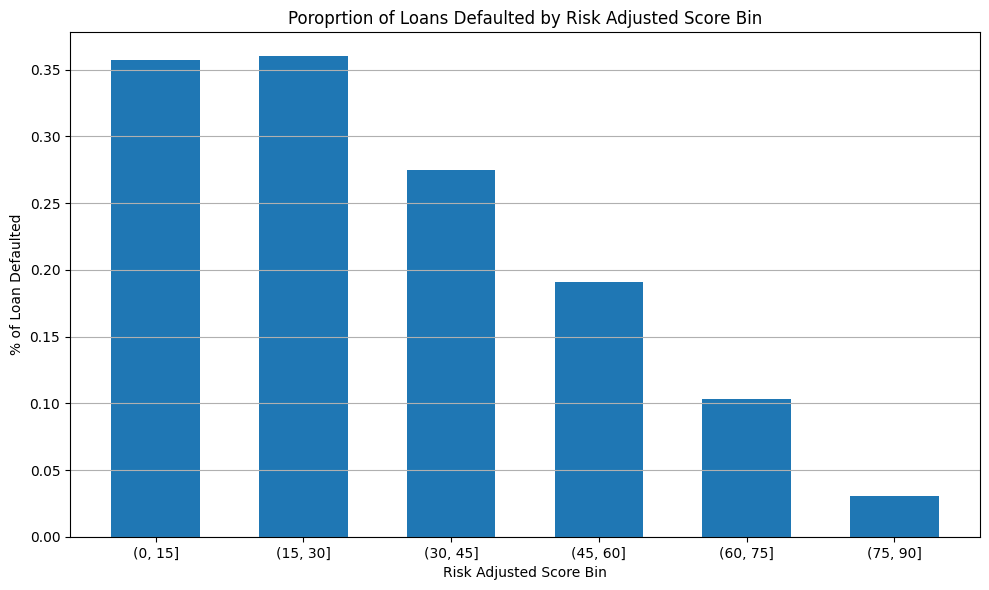

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create bins of width 10
scored_df['ScoreBin'] = pd.cut(scored_df['Risk Adjusted Score'], bins=range(0, 110, 15))

# Step 2: Group by bins and calculate mean return
bin_summary = scored_df.groupby('ScoreBin')['actual_default'].mean().reset_index()

# Step 3: Plot
plt.figure(figsize=(10, 6))
plt.bar(bin_summary['ScoreBin'].astype(str), bin_summary['actual_default'], width=0.6)
plt.xlabel("Risk Adjusted Score Bin")
plt.ylabel("% of Loan Defaulted")
plt.title("Poroprtion of Loans Defaulted by Risk Adjusted Score Bin")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


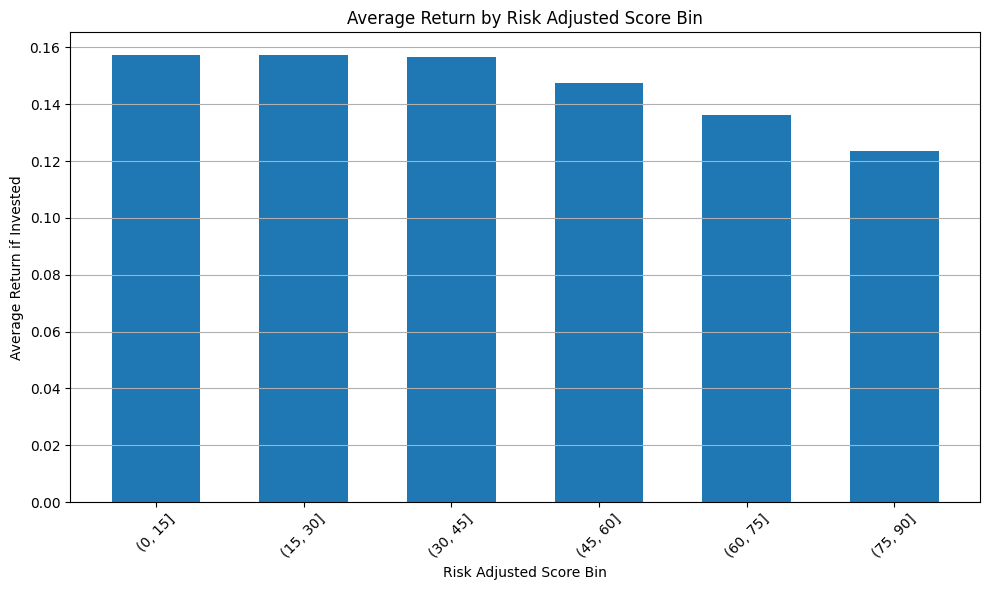

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create bins of width 10
scored_df['ScoreBin'] = pd.cut(scored_df['Risk Adjusted Score'], bins=range(0, 110, 15))

# Step 2: Group by bins and calculate mean return
bin_summary = scored_df.groupby('ScoreBin')['Return_ifInvested'].mean().reset_index()

# Step 3: Plot
plt.figure(figsize=(10, 6))
plt.bar(bin_summary['ScoreBin'].astype(str), bin_summary['Return_ifInvested'], width=0.6)
plt.xticks(rotation=45)
plt.xlabel("Risk Adjusted Score Bin")
plt.ylabel("Average Return if Invested")
plt.title("Average Return by Risk Adjusted Score Bin")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [84]:
# Select and rename columns
x = scored_df[['Risk Adjusted Score','default_probability','actual_return','predicted_recovery_pct']]
x = x.rename(columns={
    'Risk Adjusted Score': 'Risk Adjusted Score',
    'default_probability': 'Predicted Default Probability',
    'actual_return': 'Return %',
    'predicted_recovery_pct': 'Recovery %'
})

# First row
first_row = x.head(1)

# Random row with score ~50
random_50_row = x[(x['Risk Adjusted Score'] >= 48) & (x['Risk Adjusted Score'] <= 52)].sample(1, random_state=4)

# Lowest scoring loan with ~15% return
row_15_return = x[
    (x['Return %'].between(0.145, 0.155))
].sort_values(by='Risk Adjusted Score', ascending=True).head(1)

# Combine all rows
combined_df = pd.concat([first_row, random_50_row, row_15_return])
combined_df = combined_df.set_index('Risk Adjusted Score')

# Display the combined DataFrame
display(combined_df)


Predicted Default Probability  Return %  Recovery %
Risk Adjusted Score                                                     
80.381918                                 0.031653  0.152845    0.019083
49.787526                                 0.184913  0.159666    0.008602
2.862318                                  0.836549  0.154771    0.012797